In [ ]:
!wget https://zenodo.org/api/records/3445364/files-archive -O archive.zip

--2025-09-23 23:44:36--  https://zenodo.org/api/records/3445364/files-archive
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘archive.zip’

archive.zip             [            <=>     ] 194.57M  30.5MB/s    in 20s     

2025-09-23 23:44:56 (9.98 MB/s) - ‘archive.zip’ saved [204018658]



In [ ]:
!mkdir data
!unzip archive.zip -d data/

Archive:  archive.zip
 extracting: data/ov2295_clone_clusters.csv.gz  
 extracting: data/ov2295_clone_snvs.csv.gz  
 extracting: data/ov_supp_clone_allele_cn.png  
 extracting: data/ov2295_cell_metrics.csv.gz  
 extracting: data/ov2295_clone_alleles.csv.gz  
 extracting: data/ov2295_clone_breakpoints.csv.gz  
 extracting: data/ov2295_nodes.csv.gz  
 extracting: data/ov2295_cell_cn.csv.gz  
 extracting: data/ov2295_tree.pickle  
 extracting: data/ov2295_breakpoint_counts.csv.gz  
 extracting: data/ov2295_clone_cn.csv.gz  
 extracting: data/ov2295_snv_counts.csv.gz  
 extracting: data/ov_supp_sample_total_cn.png  
 extracting: data/ov_supp_sample_allele_cn.png  
 extracting: data/ov_supp_clone_total_cn.png  


In [ ]:
import pandas as pd

In [ ]:
ROOT_DIR = "data/"

In [ ]:
import pandas as pd

In [ ]:
df_clone_clusters = pd.read_csv(f"{ROOT_DIR}/ov2295_clone_clusters.csv.gz")
df_clone_clusters.sort_values(by='cell_id')

,cell_id,clone_id
0,SA1090-A96213A-R20-C09,C
1,SA1090-A96213A-R20-C11,C
99,SA1090-A96213A-R20-C12,D
209,SA1090-A96213A-R20-C13,A
335,SA1090-A96213A-R20-C17,B
...,...,...
812,SA922-A90554B-R35-C45,E
813,SA922-A90554B-R35-C49,E
890,SA922-A90554B-R35-C56,F
814,SA922-A90554B-R35-C65,E


In [ ]:
df_clone_snvs = pd.read_csv(f"{ROOT_DIR}/ov2295_clone_snvs.csv.gz")
df_clone_snvs

/tmp/ipython-input-3941203960.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clone_snvs = pd.read_csv(f"{ROOT_DIR}/ov2295_clone_snvs.csv.gz")


,chrom,coord,ref,alt,clone_id,ref_counts,alt_counts,total_counts,is_present,is_het,is_hom
0,1,985349,G,A,A,18,0,18,0,0,0
1,1,985349,G,A,B,19,0,19,0,0,0
2,1,985349,G,A,C,14,0,14,0,0,0
3,1,985349,G,A,D,18,0,18,0,0,0
4,1,985349,G,A,E,6,10,23,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
126607,X,154563943,T,A,E,0,10,13,1,1,0
126608,X,154563943,T,A,F,0,10,14,1,1,0
126609,X,154563943,T,A,G,22,0,22,0,0,0
126610,X,154563943,T,A,H,10,0,10,0,0,0


In [ ]:
df_cell_metrics = pd.read_csv(f"{ROOT_DIR}/ov2295_cell_metrics.csv.gz")
df_cell_metrics.sort_values(by='cell_id')

,cell_id,unpaired_mapped_reads,paired_mapped_reads,unpaired_duplicate_reads,paired_duplicate_reads,unmapped_reads,percent_duplicate_reads,estimated_library_size,total_reads,total_mapped_reads,...,mean_state_mads,mean_state_vars,mad_neutral_state,breakpoints,mean_copy,state_mode,log_likelihood,true_multiplier,quality,order
1813,SA1090-A96213A-R20-C06,184,3736,5,266,6334,0.077194,27529.0,13990,7656,...,8.801079e-09,0.277387,6.612847e-09,1105,2.694481,2,3442.321452,2.000000,0.000,666.0
1943,SA1090-A96213A-R20-C08,54091,3043249,19530,742185,472144,0.252609,5292268.0,6612734,6140590,...,1.355167e-01,0.346735,8.130422e-02,516,2.553902,3,-4764.668175,1.985751,0.458,780.0
1942,SA1090-A96213A-R20-C09,46152,2446667,17898,623318,425083,0.264365,4035413.0,5364570,4939487,...,4.291251e-02,0.025927,4.776725e-02,89,1.885592,2,1966.597083,1.999676,0.998,308.0
1743,SA1090-A96213A-R20-C10,38862,1861172,13768,399894,356296,0.223501,3777751.0,4117502,3761206,...,1.634896e+01,778.018305,NaN,15,71.649775,8,-26641.531423,0.777111,0.042,886.0
1744,SA1090-A96213A-R20-C11,36552,1853015,12832,419203,316488,0.235082,3536337.0,4059070,3742582,...,5.451228e-02,0.042987,5.850109e-02,89,1.885018,2,1008.649751,2.002452,1.000,296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551,SA922-A90554B-R35-C66,79455,3456790,25087,1056272,482311,0.307324,4447773.0,7475346,6993035,...,1.142069e-01,0.741109,7.613230e-02,336,4.721971,4,-6801.301540,4.025640,0.334,202.0
552,SA922-A90554B-R35-C67,101819,4285100,37573,1212820,714732,0.285437,6080607.0,9386752,8672020,...,6.870316e-02,0.302356,4.494102e-02,93,4.130080,5,-3484.153571,3.986422,0.962,258.0
549,SA922-A90554B-R35-C68,84486,3523839,25999,1055960,486692,0.301334,4649553.0,7618856,7132164,...,1.338978e-01,0.567978,9.340366e-02,282,3.774048,3,-6202.957887,2.959775,0.422,399.0
550,SA922-A90554B-R35-C69,86666,3724589,30366,1106918,561420,0.299257,4965940.0,8097264,7535844,...,6.166354e-02,0.264466,4.366547e-02,98,4.152376,5,-3388.313212,4.161776,0.968,546.0


In [ ]:
df_clone_alleles = pd.read_csv(f"{ROOT_DIR}/ov2295_clone_alleles.csv.gz")
df_clone_alleles

/tmp/ipython-input-1488976780.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clone_alleles = pd.read_csv(f"{ROOT_DIR}/ov2295_clone_alleles.csv.gz")


,chr,start,end,hap_label,clone_id,allele_1_sum,allele_2_sum,total_counts_sum
0,10,1,500000,0,E,21,1,22
1,10,1,500000,1,E,18,15,33
2,10,1,500000,2,E,577,516,1093
3,10,1,500000,3,E,10,30,40
4,10,1,500000,4,E,418,140,558
...,...,...,...,...,...,...,...,...
983674,12,133500001,134000000,4989,B,1,0,1
983675,12,133500001,134000000,4990,B,9,0,9
983676,12,133500001,134000000,4992,B,0,11,11
983677,12,133500001,134000000,4993,B,9,0,9


In [ ]:
df_clone_brkpts = pd.read_csv(f"{ROOT_DIR}/ov2295_clone_breakpoints.csv.gz")
df_clone_brkpts

,chromosome_1,strand_1,position_1,chromosome_2,strand_2,position_2,clone_id,read_count,is_present
0,1,+,2242767,1,+,2242735,A,0,False
1,1,+,2242767,1,+,2242735,B,0,False
2,1,+,2242767,1,+,2242735,C,0,False
3,1,+,2242767,1,+,2242735,D,0,False
4,1,+,2242767,1,+,2242735,E,4,True
...,...,...,...,...,...,...,...,...,...
4837,X,-,134340688,16,-,89819282,E,3,True
4838,X,-,134340688,16,-,89819282,F,0,False
4839,X,-,134340688,16,-,89819282,G,0,False
4840,X,-,134340688,16,-,89819282,H,0,False


In [ ]:
df_nodes = pd.read_csv(f"{ROOT_DIR}/ov2295_nodes.csv.gz")
df_nodes

,variant_id,node,loss,origin,presence,ml_origin,ml_presence,ml_loss
0,10:100129846:C:A,0,0.000000e+00,4.573674e-05,0.000000e+00,0,0,0
1,10:100129846:C:A,1,4.542663e-05,3.979706e-41,3.101192e-07,0,0,0
2,10:100129846:C:A,2,3.080443e-07,3.926630e-41,2.074915e-09,0,0,0
3,10:100129846:C:A,3,2.074915e-09,8.623432e-67,0.000000e+00,0,0,0
4,10:100129846:C:A,4,2.074915e-09,8.588990e-55,0.000000e+00,0,0,0
...,...,...,...,...,...,...,...,...
239151,X:99571629:G:T,12,4.783274e-116,9.932175e-01,6.782464e-03,1,1,0
239152,X:99571629:G:T,13,6.894618e-84,1.015949e-30,1.000000e+00,0,1,0
239153,X:99571629:G:T,14,6.980025e-69,1.003518e-45,1.000000e+00,0,1,0
239154,X:99571629:G:T,15,6.653350e-18,1.052790e-96,1.000000e+00,0,1,0


In [ ]:
df_cell_cn = pd.read_csv(f"{ROOT_DIR}/ov2295_cell_cn.csv.gz")
df_cell_cn.sort_values(by=['cell_id', 'chr', 'start'])

,cell_id,sample_id,library_id,chr,start,end,reads,copy,state
11251478,SA1090-A96213A-R20-C06,SA1090,A96213A,1,1,500000,0,NaN,2
11251479,SA1090-A96213A-R20-C06,SA1090,A96213A,1,500001,1000000,0,NaN,2
11251480,SA1090-A96213A-R20-C06,SA1090,A96213A,1,1000001,1500000,2,2.0,2
11251481,SA1090-A96213A-R20-C06,SA1090,A96213A,1,1500001,2000000,2,2.0,2
11251482,SA1090-A96213A-R20-C06,SA1090,A96213A,1,2000001,2500000,2,2.0,2
...,...,...,...,...,...,...,...,...,...
2389305,SA922-A90554B-R35-C70,SA922,A90554B,Y,57000001,57500000,0,NaN,0
2389306,SA922-A90554B-R35-C70,SA922,A90554B,Y,57500001,58000000,0,NaN,0
2389307,SA922-A90554B-R35-C70,SA922,A90554B,Y,58000001,58500000,0,NaN,0
2389308,SA922-A90554B-R35-C70,SA922,A90554B,Y,58500001,59000000,44,NaN,0


In [ ]:
df_snv_cnts = pd.read_csv(f"{ROOT_DIR}/ov2295_snv_counts.csv.gz")
df_snv_cnts.sort_values(by=['cell_id', 'chrom', 'coord'])

/tmp/ipython-input-73620266.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_snv_cnts = pd.read_csv(f"{ROOT_DIR}/ov2295_snv_counts.csv.gz")


,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id
1865856,4,167583433,C,G,1,0,SA1090-A96213A-R20-C06,1,SA1090
2456293,8,91421823,G,A,1,0,SA1090-A96213A-R20-C06,1,SA1090
2790188,X,115536353,T,A,0,2,SA1090-A96213A-R20-C06,2,SA1090
12063,1,5033682,G,T,2,0,SA1090-A96213A-R20-C08,2,SA1090
13465,1,14698964,A,C,1,0,SA1090-A96213A-R20-C08,1,SA1090
...,...,...,...,...,...,...,...,...,...
3254567,X,127536948,G,A,0,1,SA922-A90554B-R35-C70,1,SA922
993271,X,138263040,A,T,0,1,SA922-A90554B-R35-C70,1,SA922
2084770,X,138270131,T,C,1,0,SA922-A90554B-R35-C70,1,SA922
993588,X,143780999,C,A,0,2,SA922-A90554B-R35-C70,2,SA922


In [ ]:
# import pickle

# with open(f"{ROOT_DIR}/ov2295_tree.pickle", "rb") as f:
#     data = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

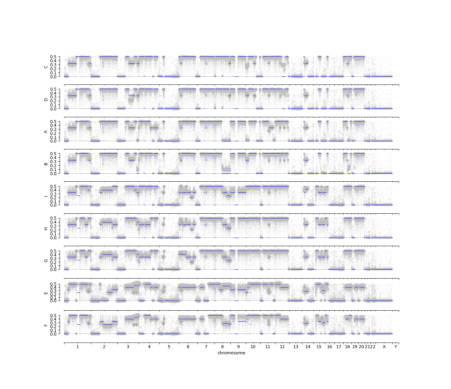

In [ ]:
img = mpimg.imread(f'{ROOT_DIR}/ov_supp_clone_allele_cn.png')
plt.imshow(img)
plt.axis('off')
plt.show()

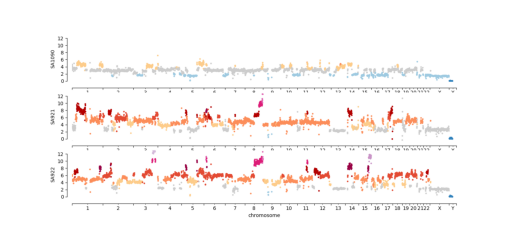

In [ ]:
img = mpimg.imread(f'{ROOT_DIR}/ov_supp_sample_total_cn.png')
plt.imshow(img)
plt.axis('off')
plt.show()

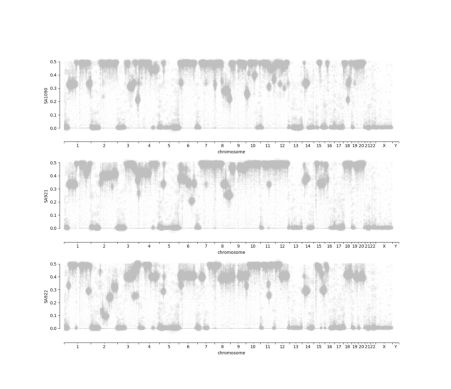

In [ ]:
img = mpimg.imread(f'{ROOT_DIR}/ov_supp_sample_allele_cn.png')
plt.imshow(img)
plt.axis('off')
plt.show()

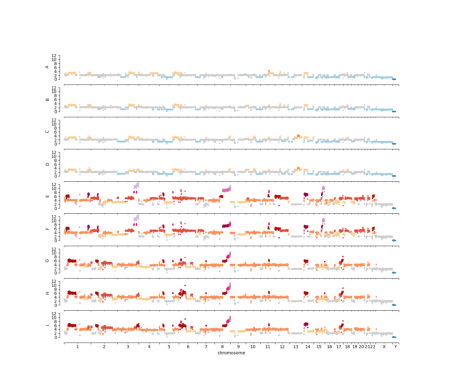

In [ ]:
img = mpimg.imread(f'{ROOT_DIR}/ov_supp_clone_total_cn.png')
plt.imshow(img)
plt.axis('off')
plt.show()

## Pooling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import SpectralBiclustering

In [ ]:
df = df_clone_snvs
df["mutation"] = df["chrom"].astype(str) + ":" + df["coord"].astype(str) + ":" + df["ref"].astype(str) + ":" + df["alt"].astype(str)
df_clone_snvs

,chrom,coord,ref,alt,clone_id,ref_counts,alt_counts,total_counts,is_present,is_het,is_hom,mutation
0,1,985349,G,A,A,18,0,18,0,0,0,1:985349:G:A
1,1,985349,G,A,B,19,0,19,0,0,0,1:985349:G:A
2,1,985349,G,A,C,14,0,14,0,0,0,1:985349:G:A
3,1,985349,G,A,D,18,0,18,0,0,0,1:985349:G:A
4,1,985349,G,A,E,6,10,23,1,1,0,1:985349:G:A
...,...,...,...,...,...,...,...,...,...,...,...,...
126607,X,154563943,T,A,E,0,10,13,1,1,0,X:154563943:T:A
126608,X,154563943,T,A,F,0,10,14,1,1,0,X:154563943:T:A
126609,X,154563943,T,A,G,22,0,22,0,0,0,X:154563943:T:A
126610,X,154563943,T,A,H,10,0,10,0,0,0,X:154563943:T:A


In [ ]:
total_table = df_clone_snvs.pivot_table(
    index='clone_id',
    columns='mutation',
    values='total_counts',
    aggfunc='sum',
    fill_value=0
)
total_table

mutation,10:100129846:C:A,10:100185101:A:G,10:100209326:T:C,10:100283942:C:T,10:10086005:G:T,10:100873589:A:T,10:101108222:C:A,10:101108223:T:C,10:101427318:G:C,10:101884473:T:A,...,X:97291714:A:T,X:97396419:C:A,X:97564955:T:C,X:97583306:G:T,X:98177771:A:C,X:98278474:C:A,X:98452192:T:C,X:98700894:C:T,X:99136386:C:T,X:99571629:G:T
clone_id,,,,,,,,,,,,,,,,,,,,,
A,10,21,5,24,24,6,24,24,14,5,...,8,11,6,23,7,11,8,1,20,3
B,6,13,7,16,30,5,9,10,12,6,...,7,12,7,5,3,9,6,3,8,9
C,13,11,6,8,23,4,15,15,5,5,...,6,12,4,8,4,11,5,4,6,10
D,13,15,5,26,36,10,19,19,11,9,...,4,8,8,7,18,20,8,7,12,7
E,27,35,27,51,54,26,64,64,66,22,...,15,26,21,18,30,27,13,21,20,28
F,16,18,15,30,24,21,31,31,29,12,...,11,12,2,16,12,8,7,13,7,12
G,18,16,16,42,45,23,38,38,52,10,...,12,12,9,13,20,19,7,17,11,22
H,14,18,16,22,20,13,23,23,21,13,...,13,5,8,6,5,11,8,10,7,5
I,24,19,19,32,26,21,31,32,30,14,...,13,18,7,10,23,8,8,9,10,10


In [ ]:
alt_table = df.pivot_table(
    index='clone_id',
    columns='mutation',
    values='alt_counts',
    aggfunc='sum',
    fill_value=0
)
alt_table

mutation,10:100129846:C:A,10:100185101:A:G,10:100209326:T:C,10:100283942:C:T,10:10086005:G:T,10:100873589:A:T,10:101108222:C:A,10:101108223:T:C,10:101427318:G:C,10:101884473:T:A,...,X:97291714:A:T,X:97396419:C:A,X:97564955:T:C,X:97583306:G:T,X:98177771:A:C,X:98278474:C:A,X:98452192:T:C,X:98700894:C:T,X:99136386:C:T,X:99571629:G:T
clone_id,,,,,,,,,,,,,,,,,,,,,
A,0,0,5,0,10,0,0,0,0,5,...,0,0,0,10,7,0,0,1,0,0
B,0,0,7,0,10,0,0,0,0,6,...,0,0,0,4,3,0,0,3,0,0
C,0,0,6,0,0,0,1,0,0,5,...,0,0,0,0,4,0,5,4,0,0
D,0,0,5,0,0,0,0,0,0,9,...,0,0,0,0,10,0,8,7,0,0
E,10,10,9,10,0,7,10,10,10,10,...,0,10,1,0,10,0,0,10,10,0
F,4,10,10,10,0,1,10,10,0,5,...,0,0,0,0,10,0,0,10,7,0
G,0,0,7,0,0,0,0,0,0,3,...,10,0,9,0,10,8,0,10,0,10
H,0,0,9,0,0,0,1,0,0,8,...,10,0,8,0,5,5,0,10,0,5
I,0,0,10,0,0,0,0,0,0,7,...,10,0,7,0,10,1,0,9,0,10


In [ ]:
frac_table = alt_table.div(total_table).replace(np.nan, 0)
frac_table

mutation,10:100129846:C:A,10:100185101:A:G,10:100209326:T:C,10:100283942:C:T,10:10086005:G:T,10:100873589:A:T,10:101108222:C:A,10:101108223:T:C,10:101427318:G:C,10:101884473:T:A,...,X:97291714:A:T,X:97396419:C:A,X:97564955:T:C,X:97583306:G:T,X:98177771:A:C,X:98278474:C:A,X:98452192:T:C,X:98700894:C:T,X:99136386:C:T,X:99571629:G:T
clone_id,,,,,,,,,,,,,,,,,,,,,
A,0.00000,0.000000,1.000000,0.000000,0.416667,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.434783,1.000000,0.000000,0.0,1.000000,0.0,0.000000
B,0.00000,0.000000,1.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.800000,1.000000,0.000000,0.0,1.000000,0.0,0.000000
C,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,0.0,0.000000
D,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.555556,0.000000,1.0,1.000000,0.0,0.000000
E,0.37037,0.285714,0.333333,0.196078,0.000000,0.269231,0.156250,0.156250,0.151515,0.454545,...,0.000000,0.384615,0.047619,0.000000,0.333333,0.000000,0.0,0.476190,0.5,0.000000
F,0.25000,0.555556,0.666667,0.333333,0.000000,0.047619,0.322581,0.322581,0.000000,0.416667,...,0.000000,0.000000,0.000000,0.000000,0.833333,0.000000,0.0,0.769231,1.0,0.000000
G,0.00000,0.000000,0.437500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,...,0.833333,0.000000,1.000000,0.000000,0.500000,0.421053,0.0,0.588235,0.0,0.454545
H,0.00000,0.000000,0.562500,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.615385,...,0.769231,0.000000,1.000000,0.000000,1.000000,0.454545,0.0,1.000000,0.0,1.000000
I,0.00000,0.000000,0.526316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.769231,0.000000,1.000000,0.000000,0.434783,0.125000,0.0,1.000000,0.0,1.000000


In [ ]:
import numpy as np

print("Any NaNs:", frac_table.isna().values.any())
print("Any +inf:", np.isinf(frac_table.values).any())
print("Any -inf:", np.isneginf(frac_table.values).any())

print(frac_table.dtypes)

Any NaNs: False
Any +inf: False
Any -inf: False
mutation
10:100129846:C:A    float64
10:100185101:A:G    float64
10:100209326:T:C    float64
10:100283942:C:T    float64
10:10086005:G:T     float64
                     ...   
X:98278474:C:A      float64
X:98452192:T:C      float64
X:98700894:C:T      float64
X:99136386:C:T      float64
X:99571629:G:T      float64
Length: 14068, dtype: object


In [ ]:
from sklearn.cluster import SpectralBiclustering
import numpy as np

model = SpectralBiclustering(n_clusters=5, method='log', random_state=0)
model.fit(frac_table.values)

# Reorder matrix by clusters
frac_biclust = frac_table.iloc[np.argsort(model.row_labels_)]
frac_biclust = frac_biclust.iloc[:, np.argsort(model.column_labels_)]

<Axes: xlabel='mutation', ylabel='clone_id'>

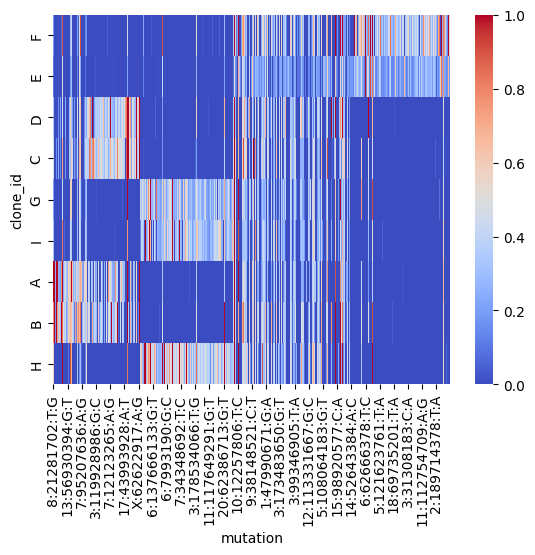

In [ ]:
import seaborn as sns
sns.heatmap(frac_biclust, cmap='coolwarm')

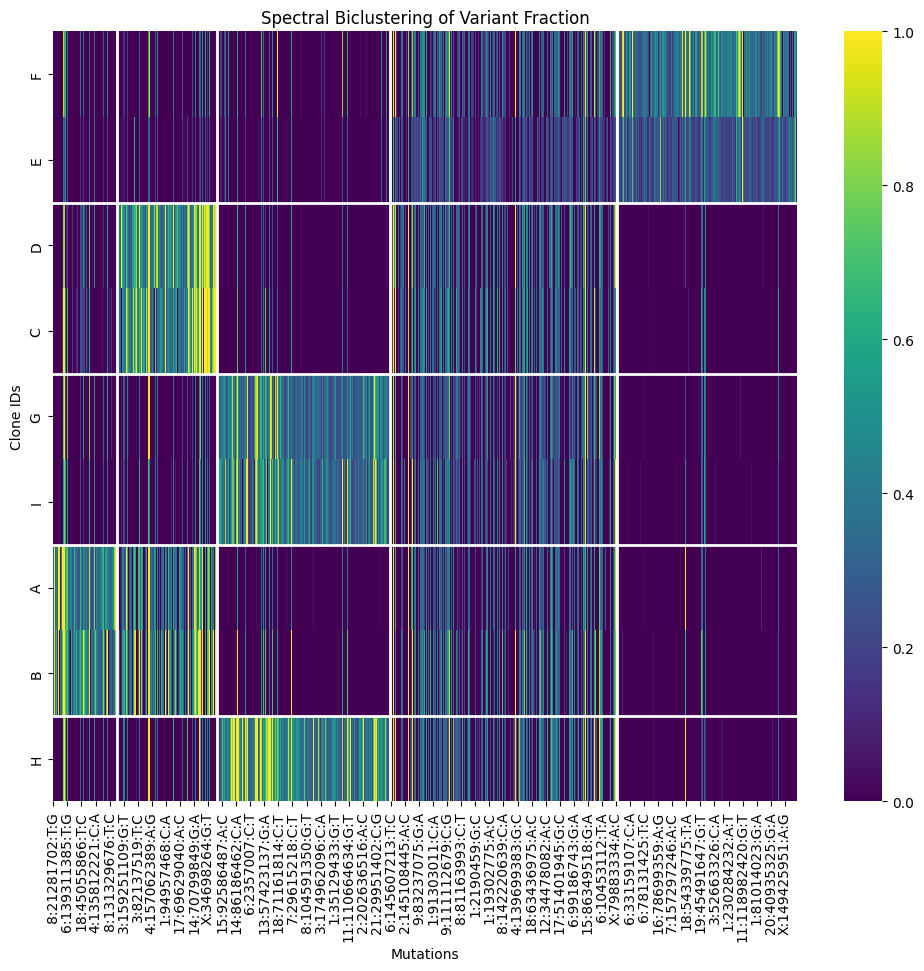

In [ ]:
# Get where the cluster boundaries are
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)

row_clusters, row_counts = np.unique(model.row_labels_[row_order], return_counts=True)
col_clusters, col_counts = np.unique(model.column_labels_[col_order], return_counts=True)

row_lines = np.cumsum(row_counts)[:-1]
col_lines = np.cumsum(col_counts)[:-1]

# Plot with boundaries
plt.figure(figsize=(12, 10))
ax = sns.heatmap(frac_biclust, cmap='viridis', cbar=True)

# Draw horizontal lines
for r in row_lines:
    ax.axhline(r, color='white', lw=2)

# Draw vertical lines
for c in col_lines:
    ax.axvline(c, color='white', lw=2)

plt.title("Spectral Biclustering of Variant Fraction")
plt.xlabel("Mutations")
plt.ylabel("Clone IDs")
plt.show()

In [ ]:
df = df_snv_cnts
df["mutation"] = df["chrom"].astype(str) + ":" + df["coord"].astype(str) + ":" + df["ref"].astype(str) + ":" + df["alt"].astype(str)
df_snv_cnts

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id,mutation
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,1:19671432:C:T
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,1:19671432:C:T
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,1:19671432:C:T
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,1:19671432:C:T
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,1:19671432:C:T
...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,5:62716827:T:A
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,5:62716827:T:A
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,5:62716827:T:A
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,5:62716827:T:A


In [ ]:
total_cells = len(df_snv_cnts["cell_id"].unique())
total_mutations = len(df_snv_cnts["mutation"].unique())

max_reads = total_cells * total_mutations

total_reads = np.sum(df_snv_cnts["total_counts"])

read_depths = total_reads / max_reads

print(read_depths)

0.1999544232696098


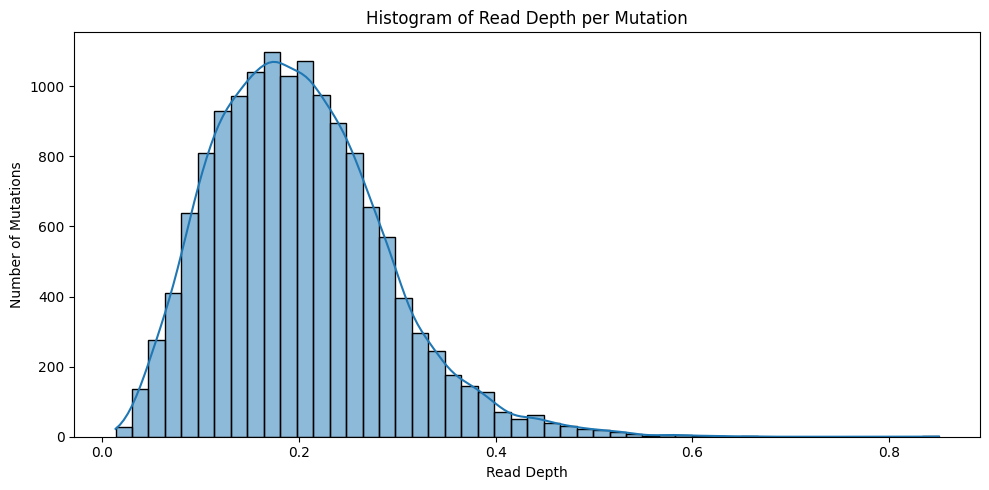

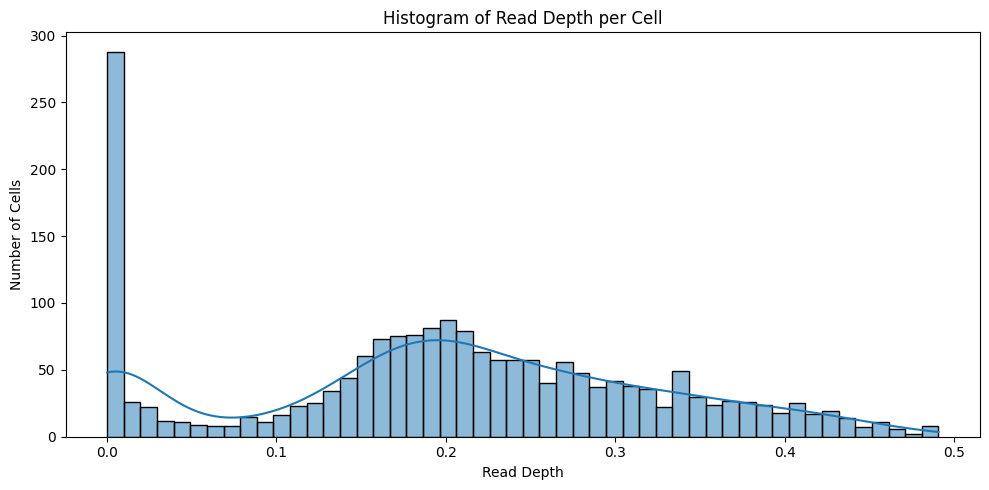

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is called df

# Histogram 1: Read depths per mutation
mutation_read_depths = df_snv_cnts.groupby("mutation")["total_counts"].sum()

plt.figure(figsize=(10, 5))
sns.histplot(mutation_read_depths / total_cells, bins=50, kde=True)
plt.title("Histogram of Read Depth per Mutation")
plt.xlabel("Read Depth")
plt.ylabel("Number of Mutations")
plt.tight_layout()
plt.show()

# Histogram 2: Read depths per cell
cell_read_depths = df_snv_cnts.groupby("cell_id")["total_counts"].sum()

plt.figure(figsize=(10, 5))
sns.histplot(cell_read_depths / total_mutations, bins=50, kde=True)
plt.title("Histogram of Read Depth per Cell")
plt.xlabel("Read Depth")
plt.ylabel("Number of Cells")
plt.tight_layout()
plt.show()

## Grouping Mutations According to Ancestree

In [ ]:
df_snv_cnts

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id,mutation
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,1:19671432:C:T
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,1:19671432:C:T
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,1:19671432:C:T
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,1:19671432:C:T
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,1:19671432:C:T
...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,5:62716827:T:A
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,5:62716827:T:A
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,5:62716827:T:A
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,5:62716827:T:A


In [ ]:
df_clone_clusters

,cell_id,clone_id
0,SA1090-A96213A-R20-C09,C
1,SA1090-A96213A-R20-C11,C
2,SA1090-A96213A-R20-C19,C
3,SA1090-A96213A-R20-C24,C
4,SA1090-A96213A-R20-C27,C
...,...,...
886,SA922-A90554B-R35-C24,F
887,SA922-A90554B-R35-C25,F
888,SA922-A90554B-R35-C37,F
889,SA922-A90554B-R35-C40,F


In [ ]:
df_snv_cnts_clusters = pd.merge(df_snv_cnts, df_clone_clusters, on='cell_id', how='left')
df_snv_cnts_clusters

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id,mutation,clone_id
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,1:19671432:C:T,NaN
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,1:19671432:C:T,H
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,1:19671432:C:T,H
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,1:19671432:C:T,NaN
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,1:19671432:C:T,I
...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,5:62716827:T:A,D
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,5:62716827:T:A,C
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,5:62716827:T:A,A
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,5:62716827:T:A,C


In [ ]:
nan_percentage = df_snv_cnts_clusters["clone_id"].isna().mean() * 100
print(f"{nan_percentage:.2f}% of clone_id values are NaN")

43.87% of clone_id values are NaN


In [ ]:
df_snv_cnts_clusters["cn_id"] = df_snv_cnts_clusters["cell_id"] + ":" + df_snv_cnts_clusters["chrom"].astype(str) + ":" + (df_snv_cnts_clusters["coord"] // 500000 * 500000 + 1).astype(str)
df_snv_cnts_clusters

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id,mutation,clone_id,cn_id
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,1:19671432:C:T,NaN,SA921-A90554A-R03-C03:1:19500001
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,1:19671432:C:T,H,SA921-A90554A-R03-C13:1:19500001
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,1:19671432:C:T,H,SA921-A90554A-R03-C21:1:19500001
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,1:19671432:C:T,NaN,SA921-A90554A-R03-C68:1:19500001
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,1:19671432:C:T,I,SA921-A90554A-R04-C10:1:19500001
...,...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,5:62716827:T:A,D,SA1090-A96213A-R27-C49:5:62500001
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,5:62716827:T:A,C,SA1090-A96213A-R30-C14:5:62500001
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,5:62716827:T:A,A,SA1090-A96213A-R30-C15:5:62500001
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,5:62716827:T:A,C,SA1090-A96213A-R33-C10:5:62500001


In [ ]:
df_cell_cn["cn_id"] = df_cell_cn['cell_id'] + ":" + df_cell_cn['chr'] + ":" + df_cell_cn['start'].astype(str)
df_cell_cn

,cell_id,sample_id,library_id,chr,start,end,reads,copy,state,cn_id
0,SA922-A90554B-R34-C70,SA922,A90554B,1,1,500000,13,NaN,6,SA922-A90554B-R34-C70:1:1
1,SA922-A90554B-R34-C70,SA922,A90554B,1,500001,1000000,442,NaN,6,SA922-A90554B-R34-C70:1:500001
2,SA922-A90554B-R34-C70,SA922,A90554B,1,1000001,1500000,461,6.672340,6,SA922-A90554B-R34-C70:1:1000001
3,SA922-A90554B-R34-C70,SA922,A90554B,1,1500001,2000000,478,5.211916,6,SA922-A90554B-R34-C70:1:1500001
4,SA922-A90554B-R34-C70,SA922,A90554B,1,2000001,2500000,594,8.384862,6,SA922-A90554B-R34-C70:1:2000001
...,...,...,...,...,...,...,...,...,...,...
12200991,SA1090-A96213A-R29-C58,SA1090,A96213A,Y,57000001,57500000,0,NaN,0,SA1090-A96213A-R29-C58:Y:57000001
12200992,SA1090-A96213A-R29-C58,SA1090,A96213A,Y,57500001,58000000,0,NaN,0,SA1090-A96213A-R29-C58:Y:57500001
12200993,SA1090-A96213A-R29-C58,SA1090,A96213A,Y,58000001,58500000,0,NaN,0,SA1090-A96213A-R29-C58:Y:58000001
12200994,SA1090-A96213A-R29-C58,SA1090,A96213A,Y,58500001,59000000,81,NaN,0,SA1090-A96213A-R29-C58:Y:58500001


In [ ]:
df_snv_cnts_clusters_cn = pd.merge(df_snv_cnts_clusters, df_cell_cn, on='cn_id', how='left', suffixes=(None, "__cn"))
df_snv_cnts_clusters_cn

,chrom,coord,ref,alt,ref_counts,alt_counts,cell_id,total_counts,sample_id,mutation,...,cn_id,cell_id__cn,sample_id__cn,library_id,chr,start,end,reads,copy,state
0,1,19671432,C,T,1,0,SA921-A90554A-R03-C03,1,SA921,1:19671432:C:T,...,SA921-A90554A-R03-C03:1:19500001,SA921-A90554A-R03-C03,SA921,A90554A,1,19500001,20000000,2,1.000000,1
1,1,19671432,C,T,2,0,SA921-A90554A-R03-C13,2,SA921,1:19671432:C:T,...,SA921-A90554A-R03-C13:1:19500001,SA921-A90554A-R03-C13,SA921,A90554A,1,19500001,20000000,776,1.944033,2
2,1,19671432,C,T,1,0,SA921-A90554A-R03-C21,1,SA921,1:19671432:C:T,...,SA921-A90554A-R03-C21:1:19500001,SA921-A90554A-R03-C21,SA921,A90554A,1,19500001,20000000,854,2.325511,2
3,1,19671432,C,T,2,0,SA921-A90554A-R03-C68,2,SA921,1:19671432:C:T,...,SA921-A90554A-R03-C68:1:19500001,SA921-A90554A-R03-C68,SA921,A90554A,1,19500001,20000000,663,1.979604,2
4,1,19671432,C,T,1,0,SA921-A90554A-R04-C10,1,SA921,1:19671432:C:T,...,SA921-A90554A-R04-C10:1:19500001,SA921-A90554A-R04-C10,SA921,A90554A,1,19500001,20000000,530,1.829550,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800279,5,62716827,T,A,1,0,SA1090-A96213A-R27-C49,1,SA1090,5:62716827:T:A,...,SA1090-A96213A-R27-C49:5:62500001,SA1090-A96213A-R27-C49,SA1090,A96213A,5,62500001,63000000,209,0.988248,1
3800280,5,62716827,T,A,1,0,SA1090-A96213A-R30-C14,1,SA1090,5:62716827:T:A,...,SA1090-A96213A-R30-C14:5:62500001,SA1090-A96213A-R30-C14,SA1090,A96213A,5,62500001,63000000,384,0.924362,1
3800281,5,62716827,T,A,1,0,SA1090-A96213A-R30-C15,1,SA1090,5:62716827:T:A,...,SA1090-A96213A-R30-C15:5:62500001,SA1090-A96213A-R30-C15,SA1090,A96213A,5,62500001,63000000,456,1.219741,1
3800282,5,62716827,T,A,1,0,SA1090-A96213A-R33-C10,1,SA1090,5:62716827:T:A,...,SA1090-A96213A-R33-C10:5:62500001,SA1090-A96213A-R33-C10,SA1090,A96213A,5,62500001,63000000,269,1.061080,1


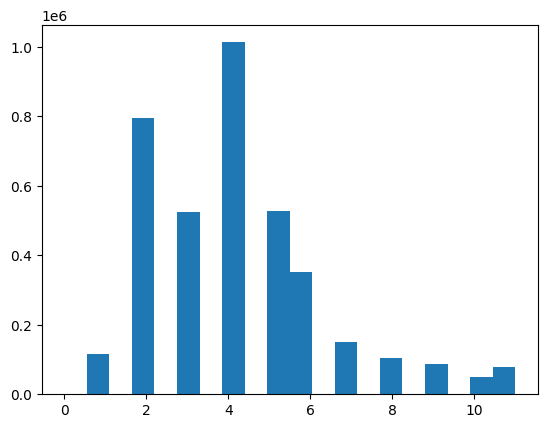

In [ ]:
plt.hist(df_snv_cnts_clusters_cn["state"], bins=20)
plt.show()

In [ ]:
df_snv_cnts_clusters_cn["has_mutation"] = ((df_snv_cnts_clusters_cn["alt_counts"] > 0) | ((df_snv_cnts_clusters_cn["state"] > 1) & (df_snv_cnts_clusters_cn["total_counts"] == 1)) ).astype(int)
df_snv_cnts_clusters_cn["has_mutation"]

,has_mutation
0,0
1,0
2,1
3,0
4,1
...,...
3800279,0
3800280,0
3800281,0
3800282,0


In [ ]:
true_percentage = df_snv_cnts_clusters_cn["has_mutation"].mean() * 100
print(f"{true_percentage:.2f}% of rows have mutation")

72.22% of rows have mutation


In [ ]:
mutation_clone_stats = (
    df_snv_cnts_clusters_cn.groupby(["mutation", "clone_id"])
      .agg(
          total_cells=("cell_id", "nunique"),       # total unique cells
          mutated_cells=("has_mutation", "sum"),     # number of mutated cells
          mean_state=("state", "mean"),              # mean state of clone
      )
)

mutation_clone_stats["percent_mutated"] = (
    mutation_clone_stats["mutated_cells"] / mutation_clone_stats["total_cells"]
)

mutation_clone_stats["state"] = mutation_clone_stats["mean_state"].round(0)

mutation_clone_stats

total_cells  mutated_cells  mean_state  \
mutation         clone_id                                           
10:100129846:C:A A                   7              1    1.142857   
                 B                   5              0    1.000000   
                 C                   9              0    1.000000   
                 D                  11              1    1.090909   
                 E                  21             18    4.047619   
...                                ...            ...         ...   
X:99571629:G:T   E                  23             19    2.000000   
                 F                  10              8    2.100000   
                 G                  15             15    2.000000   
                 H                   5              5    2.000000   
                 I                   9              9    2.000000   

                           percent_mutated  state  
mutation         clone_id                          
10:100129846:C:A A                0.142857    1.0  
                 B                0.000000    1.0  
                 C                0.000000    1.0  
                 D                0.090909    1.0  
                 E                0.857143    4.0  
...                                    ...    ...  
X:99571629:G:T   E                0.826087    2.0  
                 F                0.800000    2.0  
                 G                1.000000    2.0  
                 H                1.000000    2.0  
                 I                1.000000    2.0  

[126260 rows x 5 columns]

In [ ]:
copy_numbers = (
    mutation_clone_stats.reset_index()
    .pivot(index="clone_id", columns="mutation", values="state")
    .fillna(0)   # replace NaNs with 0
)
copy_numbers

mutation,10:100129846:C:A,10:100185101:A:G,10:100209326:T:C,10:100283942:C:T,10:10086005:G:T,10:100873589:A:T,10:101108222:C:A,10:101108223:T:C,10:101427318:G:C,10:101884473:T:A,...,X:97291714:A:T,X:97396419:C:A,X:97564955:T:C,X:97583306:G:T,X:98177771:A:C,X:98278474:C:A,X:98452192:T:C,X:98700894:C:T,X:99136386:C:T,X:99571629:G:T
clone_id,,,,,,,,,,,,,,,,,,,,,
A,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
C,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
D,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
E,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
F,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
G,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
H,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
I,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [ ]:
rho = (frac_table * copy_numbers).clip(0, 1)
rho

mutation,10:100129846:C:A,10:100185101:A:G,10:100209326:T:C,10:100283942:C:T,10:10086005:G:T,10:100873589:A:T,10:101108222:C:A,10:101108223:T:C,10:101427318:G:C,10:101884473:T:A,...,X:97291714:A:T,X:97396419:C:A,X:97564955:T:C,X:97583306:G:T,X:98177771:A:C,X:98278474:C:A,X:98452192:T:C,X:98700894:C:T,X:99136386:C:T,X:99571629:G:T
clone_id,,,,,,,,,,,,,,,,,,,,,
A,0.0,0.0,1.0,0.000000,0.833333,0.000000,0.000000,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.434783,1.000000,0.000000,0.0,1.000000,0.0,0.000000
B,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000000,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.800000,1.000000,0.000000,0.0,1.000000,0.0,0.000000
C,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.066667,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,0.0,0.000000
D,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.000000,0.555556,0.000000,1.0,1.000000,0.0,0.000000
E,1.0,1.0,1.0,0.784314,0.000000,1.000000,0.625000,0.625,0.606061,1.0,...,0.0,0.769231,0.095238,0.000000,0.666667,0.000000,0.0,0.952381,1.0,0.000000
F,1.0,1.0,1.0,1.000000,0.000000,0.190476,1.000000,1.000,0.000000,1.0,...,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000,1.0,0.000000
G,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.0,...,1.0,0.000000,1.000000,0.000000,1.000000,0.842105,0.0,1.000000,0.0,0.909091
H,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.173913,0.000,0.000000,1.0,...,1.0,0.000000,1.000000,0.000000,1.000000,0.909091,0.0,1.000000,0.0,1.000000
I,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.0,...,1.0,0.000000,1.000000,0.000000,0.869565,0.250000,0.0,1.000000,0.0,1.000000


In [ ]:
# rho = (
#     mutation_clone_stats
#     .reset_index()
#     .pivot(index="clone_id", columns="mutation", values="percent_mutated")
#     .fillna(0)   # replace NaNs with 0
# )
# rho

In [ ]:
fractional_mask = (rho > 0) & (rho < 1)

# Count per mutation (i.e. per column)
fractional_counts = fractional_mask.sum(axis=0)

fractional_counts

,0
mutation,
10:100129846:C:A,0
10:100185101:A:G,0
10:100209326:T:C,0
10:100283942:C:T,1
10:10086005:G:T,1
...,...
X:98278474:C:A,3
X:98452192:T:C,0
X:98700894:C:T,1


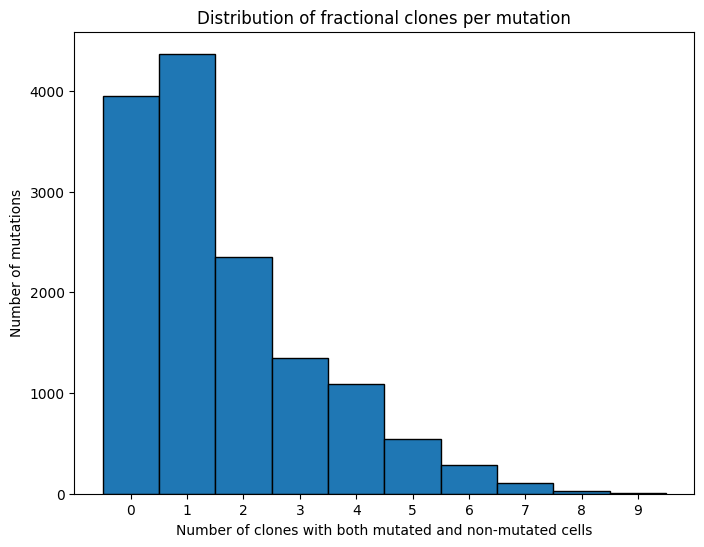

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(fractional_counts, bins=range(fractional_counts.max()+2), edgecolor="black", align="left")
plt.xlabel("Number of clones with both mutated and non-mutated cells")
plt.ylabel("Number of mutations")
plt.title("Distribution of fractional clones per mutation")
plt.xticks(range(fractional_counts.max()+1))
plt.show()

In [ ]:
distribution = fractional_counts.value_counts().sort_index()
distribution

,count
0,3953
1,4370
2,2349
3,1345
4,1087
5,539
6,283
7,103
8,27
9,12


In [ ]:
filtered_fractional_counts = fractional_counts[fractional_counts <= 1]
filtered_fractional_counts

,0
mutation,
10:100129846:C:A,0
10:100185101:A:G,0
10:100209326:T:C,0
10:100283942:C:T,1
10:10086005:G:T,1
...,...
X:97564955:T:C,1
X:98452192:T:C,0
X:98700894:C:T,1


In [ ]:
mutations_to_keep = filtered_fractional_counts.index
filtered_rho = rho.loc[:, rho.columns.isin(mutations_to_keep)]
filtered_rho

mutation,10:100129846:C:A,10:100185101:A:G,10:100209326:T:C,10:100283942:C:T,10:10086005:G:T,10:100873589:A:T,10:101108223:T:C,10:101427318:G:C,10:101884473:T:A,10:102329766:C:A,...,X:94344991:T:G,X:96387929:A:T,X:96987846:A:C,X:97291714:A:T,X:97396419:C:A,X:97564955:T:C,X:98452192:T:C,X:98700894:C:T,X:99136386:C:T,X:99571629:G:T
clone_id,,,,,,,,,,,,,,,,,,,,,
A,0.0,0.0,1.0,0.000000,0.833333,0.000000,0.000,0.000000,1.0,0.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000
B,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000
C,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,1.000000,0.0,0.000000
D,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,1.000000,0.0,0.000000
E,1.0,1.0,1.0,0.784314,0.000000,1.000000,0.625,0.606061,1.0,1.0,...,1.0,0.0,0.933333,0.0,0.769231,0.095238,0.0,0.952381,1.0,0.000000
F,1.0,1.0,1.0,1.000000,0.000000,0.190476,1.000,0.000000,1.0,1.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,1.0,0.000000
G,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,1.0,0.000000,1.0,0.000000,1.000000,0.0,1.000000,0.0,0.909091
H,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,1.0,0.000000,1.0,0.000000,1.000000,0.0,1.000000,0.0,1.000000
I,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,1.0,0.000000,1.0,0.000000,1.000000,0.0,1.000000,0.0,1.000000


In [ ]:
from sklearn.cluster import SpectralBiclustering
import numpy as np

model = SpectralBiclustering(n_clusters=7, method='log', random_state=0)
model.fit(rho.values)

# Reorder matrix by clusters
frac_biclust = rho.iloc[np.argsort(model.row_labels_)]
frac_biclust = frac_biclust.iloc[:, np.argsort(model.column_labels_)]

<Axes: xlabel='mutation', ylabel='clone_id'>

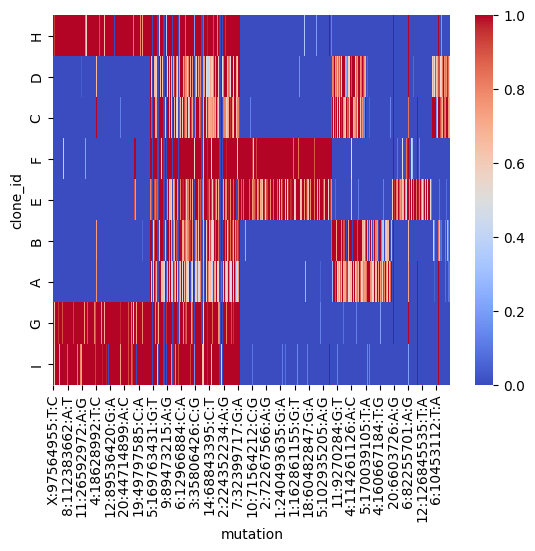

In [ ]:
import seaborn as sns
sns.heatmap(frac_biclust, cmap='coolwarm')

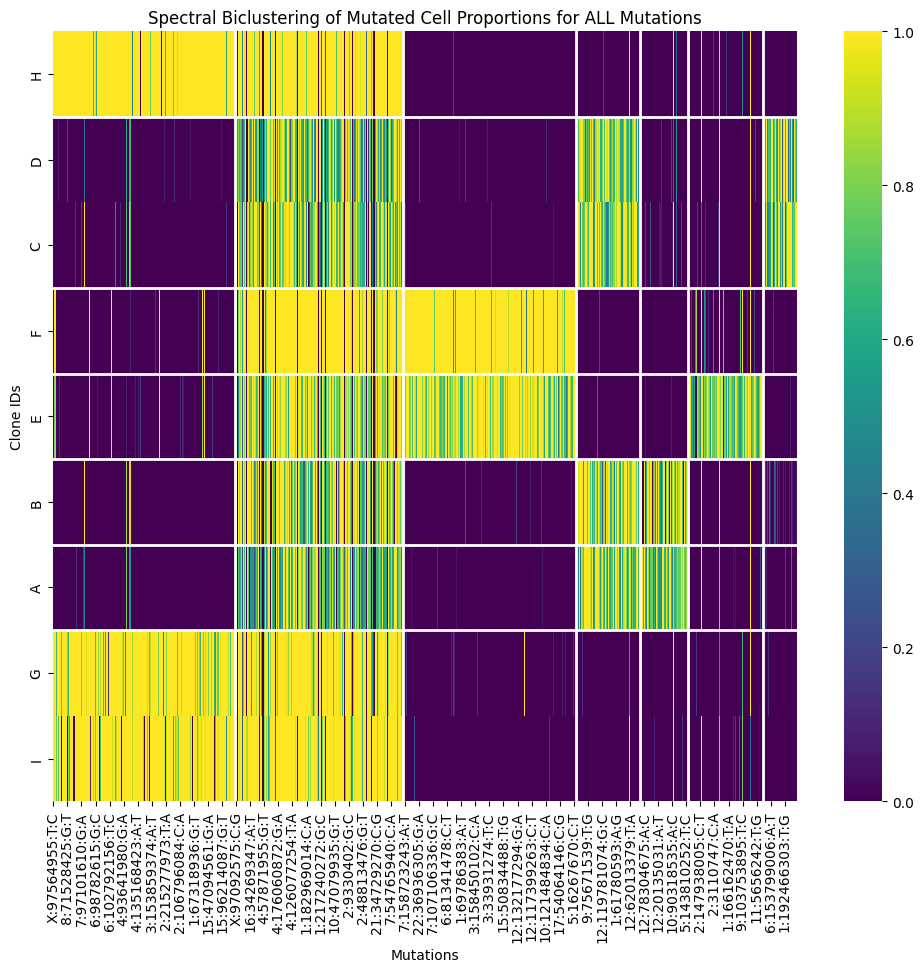

In [ ]:
# Get where the cluster boundaries are
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)

row_clusters, row_counts = np.unique(model.row_labels_[row_order], return_counts=True)
col_clusters, col_counts = np.unique(model.column_labels_[col_order], return_counts=True)

row_lines = np.cumsum(row_counts)[:-1]
col_lines = np.cumsum(col_counts)[:-1]

# Plot with boundaries
plt.figure(figsize=(12, 10))
ax = sns.heatmap(frac_biclust, cmap='viridis', cbar=True)

# Draw horizontal lines
for r in row_lines:
    ax.axhline(r, color='white', lw=2)

# Draw vertical lines
for c in col_lines:
    ax.axvline(c, color='white', lw=2)

plt.title("Spectral Biclustering of Mutated Cell Proportions for ALL Mutations")
plt.xlabel("Mutations")
plt.ylabel("Clone IDs")
plt.show()

In [ ]:
from sklearn.cluster import SpectralBiclustering
import numpy as np

model = SpectralBiclustering(n_clusters=7, method='log', random_state=0)
model.fit(filtered_rho.values)

# Reorder matrix by clusters
frac_biclust = filtered_rho.iloc[np.argsort(model.row_labels_)]
frac_biclust = frac_biclust.iloc[:, np.argsort(model.column_labels_)]

<Axes: xlabel='mutation', ylabel='clone_id'>

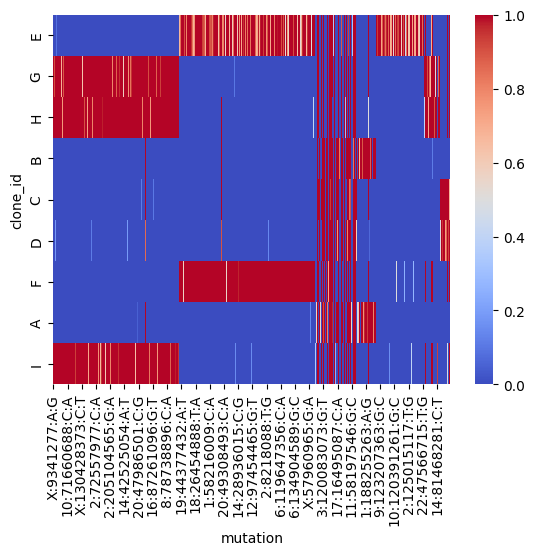

In [ ]:
import seaborn as sns
sns.heatmap(frac_biclust, cmap='coolwarm')

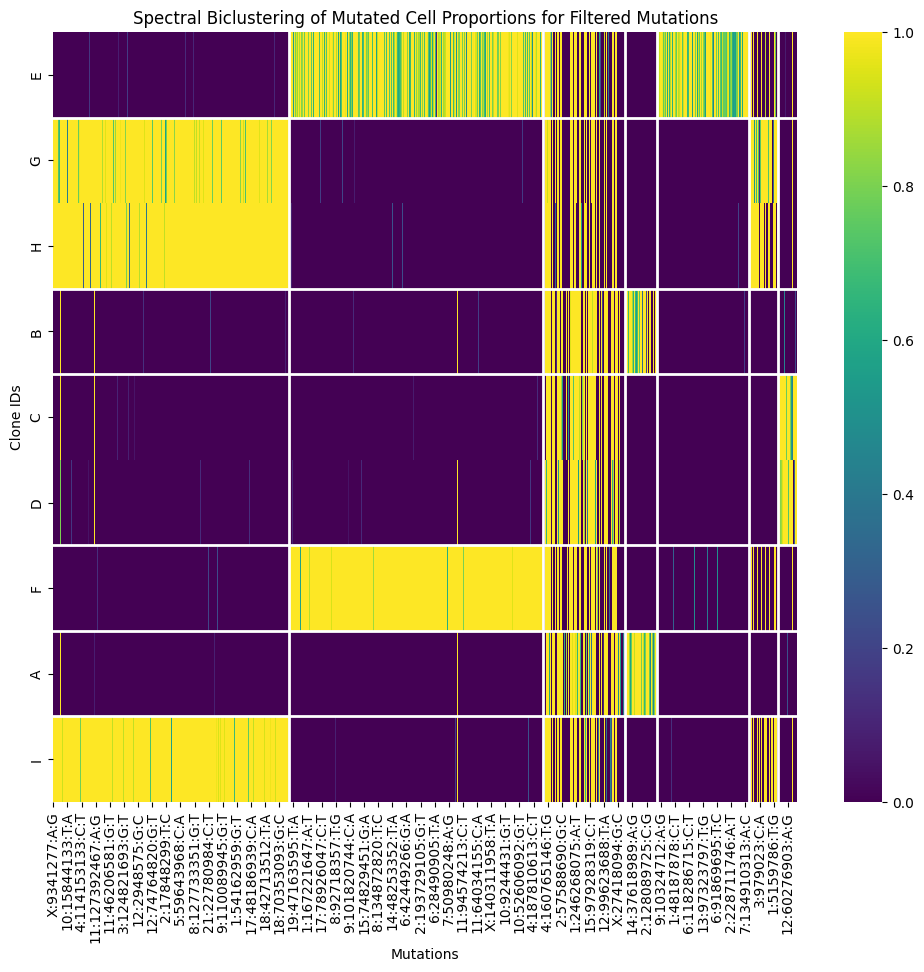

In [ ]:
# Get where the cluster boundaries are
row_order = np.argsort(model.row_labels_)
col_order = np.argsort(model.column_labels_)

row_clusters, row_counts = np.unique(model.row_labels_[row_order], return_counts=True)
col_clusters, col_counts = np.unique(model.column_labels_[col_order], return_counts=True)

row_lines = np.cumsum(row_counts)[:-1]
col_lines = np.cumsum(col_counts)[:-1]

# Plot with boundaries
plt.figure(figsize=(12, 10))
ax = sns.heatmap(frac_biclust, cmap='viridis', cbar=True)

# Draw horizontal lines
for r in row_lines:
    ax.axhline(r, color='white', lw=2)

# Draw vertical lines
for c in col_lines:
    ax.axvline(c, color='white', lw=2)

plt.title("Spectral Biclustering of Mutated Cell Proportions for Filtered Mutations")
plt.xlabel("Mutations")
plt.ylabel("Clone IDs")
plt.show()

In [ ]:
clone_id = "A"

In [ ]:
rho_clone = (
    filtered_rho.loc[clone_id]  # select row for that clone
    .rename("rho")              # rename Series name
    .reset_index()              # make mutation a column
    .rename(columns={"index": "mutation"})
)
rho_clone

,mutation,rho
0,10:100129846:C:A,0.000000
1,10:100185101:A:G,0.000000
2,10:100209326:T:C,1.000000
3,10:100283942:C:T,0.000000
4,10:10086005:G:T,0.833333
...,...,...
8318,X:97564955:T:C,0.000000
8319,X:98452192:T:C,0.000000
8320,X:98700894:C:T,1.000000
8321,X:99136386:C:T,0.000000


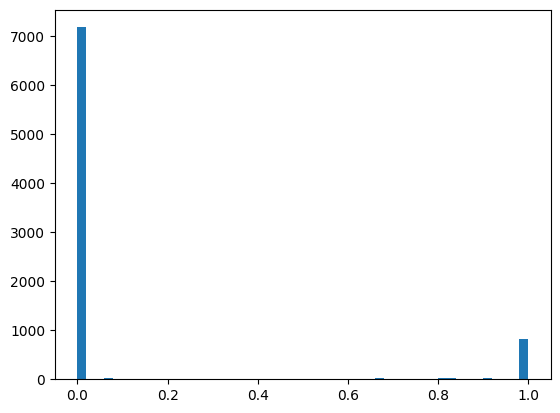

In [ ]:
plt.hist(rho_clone["rho"], bins=50)
plt.show()

In [ ]:
rho_clone_filt = rho_clone[(rho_clone["rho"] > 0) & (rho_clone["rho"] < 1)]
rho_clone_filt

,mutation,rho
4,10:10086005:G:T,0.833333
111,10:119760087:C:A,0.133333
112,10:120287412:T:C,0.454545
120,10:122029100:T:A,0.142857
175,10:15802282:G:C,0.666667
...,...,...
8262,X:69289591:G:T,0.384615
8267,X:72435008:G:A,0.444444
8297,X:86958128:G:A,0.909091
8308,X:92835183:T:C,0.666667


In [ ]:
# Create mutation x mutation matrix
M = rho_clone_filt["rho"].values[:, None] - rho_clone_filt["rho"].values[None, :]
M_df = pd.DataFrame(M, index=rho_clone_filt["mutation"], columns=rho_clone_filt["mutation"])
M_df

mutation,10:10086005:G:T,10:119760087:C:A,10:120287412:T:C,10:122029100:T:A,10:15802282:G:C,10:26684158:T:G,10:28232968:T:C,10:59012290:T:C,10:61484360:C:G,10:64536931:T:C,...,X:145177660:G:T,X:16115016:T:G,X:24808022:T:A,X:31092632:A:T,X:43834748:A:T,X:69289591:G:T,X:72435008:G:A,X:86958128:G:A,X:92835183:T:C,X:93127003:G:A
mutation,,,,,,,,,,,,,,,,,,,,,
10:10086005:G:T,0.000000,0.700000,0.378788,0.690476,0.166667,0.208333,0.245098,-0.119048,0.357143,0.064103,...,0.547619,0.208333,0.064103,-0.075758,0.277778,0.448718,0.388889,-0.075758,0.166667,0.000000
10:119760087:C:A,-0.700000,0.000000,-0.321212,-0.009524,-0.533333,-0.491667,-0.454902,-0.819048,-0.342857,-0.635897,...,-0.152381,-0.491667,-0.635897,-0.775758,-0.422222,-0.251282,-0.311111,-0.775758,-0.533333,-0.700000
10:120287412:T:C,-0.378788,0.321212,0.000000,0.311688,-0.212121,-0.170455,-0.133690,-0.497835,-0.021645,-0.314685,...,0.168831,-0.170455,-0.314685,-0.454545,-0.101010,0.069930,0.010101,-0.454545,-0.212121,-0.378788
10:122029100:T:A,-0.690476,0.009524,-0.311688,0.000000,-0.523810,-0.482143,-0.445378,-0.809524,-0.333333,-0.626374,...,-0.142857,-0.482143,-0.626374,-0.766234,-0.412698,-0.241758,-0.301587,-0.766234,-0.523810,-0.690476
10:15802282:G:C,-0.166667,0.533333,0.212121,0.523810,0.000000,0.041667,0.078431,-0.285714,0.190476,-0.102564,...,0.380952,0.041667,-0.102564,-0.242424,0.111111,0.282051,0.222222,-0.242424,0.000000,-0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X:69289591:G:T,-0.448718,0.251282,-0.069930,0.241758,-0.282051,-0.240385,-0.203620,-0.567766,-0.091575,-0.384615,...,0.098901,-0.240385,-0.384615,-0.524476,-0.170940,0.000000,-0.059829,-0.524476,-0.282051,-0.448718
X:72435008:G:A,-0.388889,0.311111,-0.010101,0.301587,-0.222222,-0.180556,-0.143791,-0.507937,-0.031746,-0.324786,...,0.158730,-0.180556,-0.324786,-0.464646,-0.111111,0.059829,0.000000,-0.464646,-0.222222,-0.388889
X:86958128:G:A,0.075758,0.775758,0.454545,0.766234,0.242424,0.284091,0.320856,-0.043290,0.432900,0.139860,...,0.623377,0.284091,0.139860,0.000000,0.353535,0.524476,0.464646,0.000000,0.242424,0.075758


In [ ]:
threshold = 0.01  # example threshold

In [ ]:
import networkx as nx

G = nx.DiGraph()
mutations = rho_clone_filt["mutation"].tolist()
G.add_nodes_from(mutations)

for i in mutations:
    for j in mutations:
        if i <= j:
            continue
        diff = M_df.loc[i, j]

        if abs(diff) < threshold:
            # bidirectional
            G.add_edge(i, j)
            G.add_edge(j, i)
        elif diff > 0:
            # Fi > Fj -> i -> j
            G.add_edge(i, j)
        else:
            # Fj > Fi -> j -> i
            G.add_edge(j, i)


In [ ]:
components = list(nx.strongly_connected_components(G))

In [ ]:
len(components)

39

In [ ]:
components

[{'10:119760087:C:A',
  '10:122029100:T:A',
  '10:66311180:A:C',
  '10:79268444:G:C',
  '10:92289714:T:A',
  '11:116971610:C:A',
  '11:122135229:T:G',
  '11:26600869:G:C',
  '11:29262528:T:C',
  '11:82797951:G:T',
  '12:3931110:C:T',
  '13:82972775:T:C',
  '13:99170932:C:A',
  '14:101691171:T:G',
  '14:29401988:C:A',
  '14:64518882:A:G',
  '17:48186939:C:A',
  '1:102610902:G:C',
  '1:116747729:G:A',
  '1:182272242:G:A',
  '1:199766322:T:A',
  '1:223527606:C:A',
  '1:242247231:C:T',
  '1:243639130:G:A',
  '1:75710433:C:T',
  '1:92235040:G:T',
  '1:94557833:T:A',
  '1:98186239:A:C',
  '20:38760433:G:C',
  '20:45218121:T:G',
  '21:39723410:G:T',
  '2:100276002:G:T',
  '2:11241594:A:G',
  '2:115272199:A:C',
  '2:124283479:G:T',
  '2:181764491:C:A',
  '2:22433863:C:T',
  '2:47942905:C:G',
  '2:71972755:C:A',
  '3:194161975:G:A',
  '3:2698815:G:A',
  '4:55790972:G:A',
  '5:120142537:C:A',
  '5:23088463:C:A',
  '5:3623017:T:C',
  '6:148465409:G:C',
  '7:116796037:G:C',
  '7:137130200:C:A',
  

In [ ]:
Q = nx.quotient_graph(G, components, create_using=nx.DiGraph)

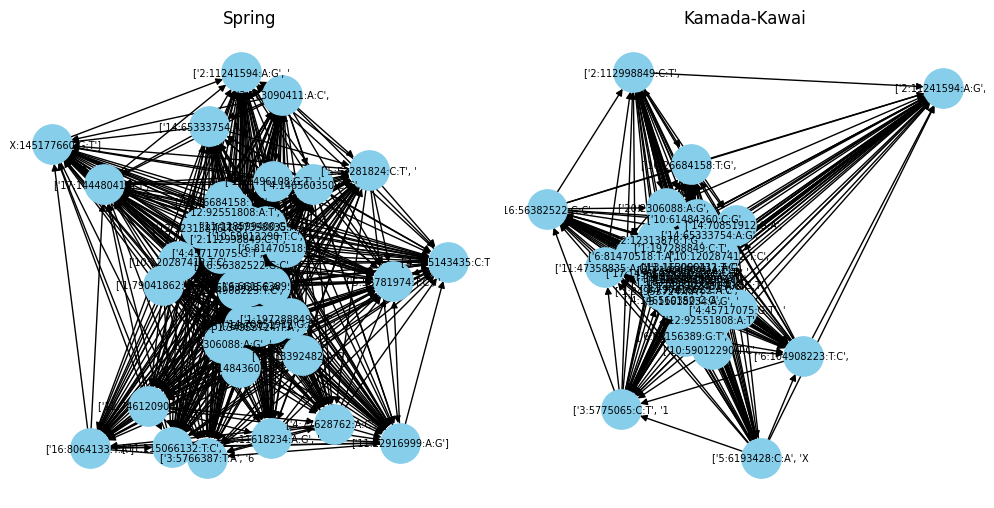

In [ ]:
layouts = {
     "Spring": nx.spring_layout(Q, seed=42, k=1.5),
    "Kamada-Kawai": nx.kamada_kawai_layout(Q),
    # "Circular": nx.circular_layout(Q),
    # "Shell": nx.shell_layout(Q),
    # "Spectral": nx.spectral_layout(Q)
}

plt.figure(figsize=(15,10))
for i, (name, pos) in enumerate(layouts.items(), 1):
    plt.subplot(2, 3, i)
    nx.draw(
        Q, pos, with_labels=True,
        labels={n: str(list(n))[:20] for n in Q.nodes},
        node_size=800, node_color="skyblue", font_size=7
    )
    plt.title(name)

plt.tight_layout()
plt.show()


In [ ]:
rows = [(mutation, comp_id)
        for comp_id, comp in enumerate(components)
        for mutation in comp]

clone_map = pd.DataFrame(rows, columns=["mutation", "clone"])

clone_map

,mutation,clone
0,2:11241594:A:G,0
1,2:71972755:C:A,0
2,1:94557833:T:A,0
3,11:26600869:G:C,0
4,2:181764491:C:A,0
...,...,...
320,3:28361578:A:T,37
321,13:58482420:T:C,37
322,1:30310953:C:A,37
323,1:238392482:A:G,38


In [ ]:
O = clone_map.assign(value=1).pivot_table(index='clone', columns='mutation', values='value', fill_value=0)
O

mutation,10:10086005:G:T,10:119760087:C:A,10:120287412:T:C,10:122029100:T:A,10:15802282:G:C,10:26684158:T:G,10:28232968:T:C,10:59012290:T:C,10:61484360:C:G,10:64536931:T:C,...,X:145177660:G:T,X:16115016:T:G,X:24808022:T:A,X:31092632:A:T,X:43834748:A:T,X:69289591:G:T,X:72435008:G:A,X:86958128:G:A,X:92835183:T:C,X:93127003:G:A
clone,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
clone_counts = clone_map.groupby("clone").size().reset_index(name="frequency")
clone_counts

,clone,frequency
0,0,59
1,1,2
2,2,2
3,3,2
4,4,1
5,5,1
6,6,1
7,7,2
8,8,1
9,9,2


In [ ]:
clone_map_rho = pd.merge(clone_map, rho_clone, on="mutation", how="left")
clone_map_rho

,mutation,clone,rho
0,2:11241594:A:G,0,0.054054
1,2:71972755:C:A,0,0.047619
2,1:94557833:T:A,0,0.057692
3,11:26600869:G:C,0,0.117647
4,2:181764491:C:A,0,0.057143
...,...,...,...
320,3:28361578:A:T,37,0.952381
321,13:58482420:T:C,37,0.952381
322,1:30310953:C:A,37,0.952381
323,1:238392482:A:G,38,0.967742


In [ ]:
clone_stats = (
    clone_map_rho.groupby("clone")
      .agg(mean_rho=("rho", "mean"), n_mutations=("rho", "size"))
      .reset_index()
      .sort_values("mean_rho", ascending=False)
)

clone_stats

,clone,mean_rho,n_mutations
38,38,0.967742,2
37,37,0.952381,9
36,36,0.938817,8
35,35,0.923077,4
34,34,0.908696,23
33,33,0.887800,6
32,32,0.869916,4
31,31,0.857143,7
30,30,0.832709,19
29,29,0.810811,2


In [ ]:
mutation_to_clone = dict(zip(clone_map["mutation"], clone_map["clone"]))
mapping = {node: mutation_to_clone[next(iter(node))] for node in Q.nodes()}
Q_relabelled = nx.relabel_nodes(Q, mapping)
Q_relabelled

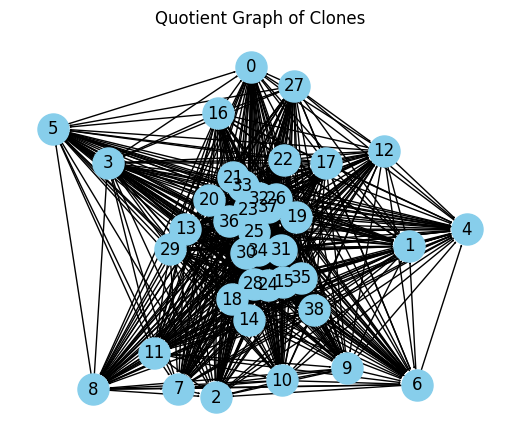

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Optionally, set a layout
pos = nx.spring_layout(Q_relabelled, seed=42, k=1.5)  # positions for all nodes

plt.figure(figsize=(5, 4))
nx.draw(
    Q_relabelled,
    pos,
    with_labels=True,      # show node labels (clone IDs)
    node_color='skyblue',  # node color
    node_size=500,        # size of nodes
    arrowsize=1,          # arrow size for directed edges
    font_size=12
)
plt.title("Quotient Graph of Clones")
plt.show()


## Formulate constraints of ancestree

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.9 MB/s eta 0:00:00


In [ ]:
clone_ids = clone_stats["clone"].tolist()
mean_rho = np.array(clone_stats["mean_rho"].tolist())

In [ ]:
O = np.eye(len(clone_ids))
O

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
import pulp
import numpy as np
from collections import defaultdict

m = 1
n = len(clone_ids)
nodes = list(range(n))    # 0..9
tol = 1e-9
epsilon = 0.05

# Build ancestry arcs A
A = []
for j in nodes:
    for k in nodes:
        if j == k:
            continue
        if mean_rho[int(j)] + tol >= mean_rho[int(k)]:
            A.append((j, k))

root = 'R'
A0 = list(A) + [(root, v) for v in nodes]


# bounds (make sure to use floats)
f_tilde = mean_rho.copy()
f_low = np.clip(f_tilde - epsilon, 0.0, 1.0)
f_high = np.clip(f_tilde + epsilon, 0.0, 1.0)


# --- Build MILP ---
prob = pulp.LpProblem("VAFFP_from_meanrho", pulp.LpMaximize)

# rename dicts to clear names to avoid accidental shadowing
x_vars = { (u,v): pulp.LpVariable(f"x_{u}_{v}", cat="Binary") for (u,v) in A0 }
f_vars = { (0,j): pulp.LpVariable(f"f_0_{j}", lowBound=float(f_low[int(j)]), upBound=float(f_high[int(j)]), cat="Continuous")
           for j in nodes }

clones = nodes               # or clone_ids
mutations_list = list(range(n))  # from your observed matrix

B_vars = pulp.LpVariable.dicts(
    "B",
    [(c, m) for c in clones for m in mutations_list],
    cat="Binary"
)

y_vars = {}
for (vj, vk) in A0:
    if vj == root:
        ub = 0.0
    else:
        ub = float(f_high[int(vj)])
    y_vars[(0, vj, vk)] = pulp.LpVariable(f"y_0_{vj}_{vk}", lowBound=0, upBound=ub, cat="Continuous")

u_vars = { (0,j): pulp.LpVariable(f"u_0_{j}", lowBound=0, cat="Continuous") for j in nodes }

# Objective
prob += (pulp.lpSum([x_vars[e] for e in x_vars]) - (1.0/(m*n)) * pulp.lpSum([u_vars[(0,j)] for j in nodes]))

# single root outgoing
prob += pulp.lpSum([x_vars[(root, v)] for v in nodes]) == 1, "SingleRootOutgoing"

# adjacency maps
d_plus = defaultdict(list)
d_minus = defaultdict(list)
for (u,v) in A0:
    d_plus[u].append(v)
    d_minus[v].append(u)

# parent incoming requirement for original A (not including root arcs)
for (vk, vl) in A:
    prob += x_vars[(vk, vl)] <= pulp.lpSum([ x_vars[(vj, vk)] for vj in d_minus[vk] ]), f"ParentIncoming_{vk}_{vl}"

# at most one incoming
for vk in nodes:
    incs = [ x_vars[(vj, vk)] for vj in d_minus[vk] ]
    if incs:
        prob += pulp.lpSum(incs) <= 1, f"AtMostOneIncoming_{vk}"

# linearization (unchanged except remove root special-case if you want root to be normal)
for (vj, vk) in A0:
    Y = y_vars[(0, vj, vk)]
    if vj == root:
        # if you do not have an f_vars entry for 'root' (we often don't), force y_root_v = 0
        prob += Y == 0, f"y_root_zero_{vj}_{vk}"
    else:
        fvar = f_vars[(0, int(vj))]
        fplus = float(f_high[int(vj)])
        X = x_vars[(vj, vk)]
        prob += Y <= fvar, f"y_le_fvar_{vj}_{vk}"
        prob += Y <= fplus * X, f"y_le_fplusx_{vj}_{vk}"
        prob += Y >= fvar - fplus * (1 - X), f"y_ge_lin_{vj}_{vk}"
        # Y >= 0 already enforced by variable lowBound=0

# Correct sum condition (parent-centric): sum outgoing y from parent j <= f_j
for j in nodes:
    j_int = int(j)
    outgoing_y = [ y_vars[(0, j, k)] for k in d_plus[j] ]
    if outgoing_y:
        prob += pulp.lpSum(outgoing_y) <= f_vars[(0, j_int)], f"SumCondition_parent_{j}"

# absolute deviation constraints: ensure we use int indices and cast numpy scalars to float
for j in nodes:
    j_int = int(j)
    ft = float(f_tilde[j_int])
    fvar = f_vars[(0, j_int)]
    uvar = u_vars[(0, j_int)]
    prob += uvar >= (ft - fvar), f"u_ge_posdiff_{j_int}"
    prob += uvar >= (fvar - ft), f"u_ge_negdiff_{j_int}"

## Construcing B
for j in nodes:
    j_int = int(j)
    for m in mutations_list:
        if O[j_int][m] == 1:
            prob += B_vars[(j_int, m)] == 1  # adjust if multiple roots

for (parent, child) in A0:
    if parent == root:
        continue
    for m in mutations_list:
        prob += B_vars[(child, m)] >= B_vars[(int(parent), m)] + x_vars[(parent, child)] - 1

# new auxiliary variables
Z_vars = {
    (p, c, m): pulp.LpVariable(f"Z_{p}_{c}_{m}", cat="Binary")
    for (p, c) in A0 if p != root
    for m in mutations_list
}

# linearization constraints
for (p, c) in A0:
    if p == root:
        continue
    for m in mutations_list:
        Z = Z_vars[(p, c, m)]
        X = x_vars[(p, c)]
        Bp = B_vars[(p, m)]
        # linearization
        prob += Z <= X
        prob += Z <= Bp
        prob += Z >= X + Bp - 1

# final B consistency constraints
for c in nodes:
    for m in mutations_list:
        parent_terms = [Z_vars[(p, int(c), m)] for p in d_minus[c] if p != root]
        prob += B_vars[(int(c), m)] <= O[int(c), m] + pulp.lpSum(parent_terms), f"B_consistency_{c}_{m}"



# Solve
solver = pulp.PULP_CBC_CMD(msg=1, timeLimit=120)
prob.solve(solver)

print("Status:", pulp.LpStatus[prob.status])
selected = [(u,v) for (u,v), var in x_vars.items() if var.varValue is not None and var.varValue > 0.5]
print("Selected arcs (index form):", selected)

# Map to clone ids
for (u,v) in selected:
    parent = 'R' if u == root else f"clone_{clone_ids[int(u)]}"
    child  = f"clone_{clone_ids[int(v)]}"
    print(parent, "->", child)


Status: Optimal
Selected arcs (index form): [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), ('R', 0)]
clone_38 -> clone_37
clone_37 -> clone_36
clone_36 -> clone_35
clone_35 -> clone_34
clone_34 -> clone_33
clone_33 -> clone_32
R -> clone_38


In [ ]:
import numpy as np

B_matrix = np.zeros((len(nodes), len(mutations_list)), dtype=int)

for j in nodes:
    for m_idx, mut in enumerate(mutations_list):
        val = pulp.value(B_vars[(j, mut)])
        B_matrix[j, m_idx] = int(round(val))  # round for safety
print("B matrix (clones × mutations):")
print(B_matrix)
print(O.mean())
print(B_matrix.mean())

B matrix (clones × mutations):
[[1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
0.02564102564102564
0.03944773175542406


In [ ]:
B_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 19.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
from collections import defaultdict
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

m = 1
n = len(clone_ids)
nodes = list(range(n))    # 0..n-1
tol = 1e-9
epsilon = 0.05

params = {
    "WLSACCESSID": '85dfeec1-65a1-402f-9425-7465d0f3a229',
    "WLSSECRET": 'f755a3a4-dba0-444d-8bc8-d8e781d8a05c',
    "LICENSEID": 2687964,
}
env = gp.Env(params=params)

# Build ancestry arcs A
A = []
for j in nodes:
    for k in nodes:
        if j == k:
            continue
        if mean_rho[int(j)] + tol >= mean_rho[int(k)]:
            A.append((j, k))

root = 'R'
A0 = list(A) + [(root, v) for v in nodes]

# bounds
f_tilde = mean_rho.copy()
f_low = np.clip(f_tilde - epsilon, 0.0, 1.0)
f_high = np.clip(f_tilde + epsilon, 0.0, 1.0)

# --- Build MILP in gurobipy ---
mdl = Model("VAFFP_from_meanrho", env=env)

# Variables
x_vars = mdl.addVars(A0, vtype=GRB.BINARY, name="x")

f_vars = {
    (0, j): mdl.addVar(lb=float(f_low[int(j)]), ub=float(f_high[int(j)]), vtype=GRB.CONTINUOUS, name=f"f_0_{j}")
    for j in nodes
}

clones = nodes
mutations_list = list(range(n))

B_vars = mdl.addVars([(c, m) for c in clones for m in mutations_list], vtype=GRB.BINARY, name="B")

y_vars = {}
for (vj, vk) in A0:
    if vj == root:
        ub = 0.0
    else:
        ub = float(f_high[int(vj)])
    y_vars[(0, vj, vk)] = mdl.addVar(lb=0, ub=ub, vtype=GRB.CONTINUOUS, name=f"y_0_{vj}_{vk}")

u_vars = {(0, j): mdl.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"u_0_{j}") for j in nodes}

mdl.update()

# Objective
mdl.setObjective(
    quicksum(x_vars[e] for e in x_vars)
    - (1.0 / (m * n)) * quicksum(u_vars[(0, j)] for j in nodes),
    GRB.MAXIMIZE
)

# Single root outgoing
mdl.addConstr(quicksum(x_vars[(root, v)] for v in nodes) == 1, "SingleRootOutgoing")

# adjacency maps
d_plus = defaultdict(list)
d_minus = defaultdict(list)
for (u, v) in A0:
    d_plus[u].append(v)
    d_minus[v].append(u)

# Parent incoming requirement
for (vk, vl) in A:
    mdl.addConstr(
        x_vars[(vk, vl)] <= quicksum(x_vars[(vj, vk)] for vj in d_minus[vk]),
        f"ParentIncoming_{vk}_{vl}"
    )

# At most one incoming
for vk in nodes:
    incs = [x_vars[(vj, vk)] for vj in d_minus[vk]]
    if incs:
        mdl.addConstr(quicksum(incs) <= 1, f"AtMostOneIncoming_{vk}")

# linearization constraints
for (vj, vk) in A0:
    Y = y_vars[(0, vj, vk)]
    if vj == root:
        mdl.addConstr(Y == 0, f"y_root_zero_{vj}_{vk}")
    else:
        fvar = f_vars[(0, int(vj))]
        fplus = float(f_high[int(vj)])
        X = x_vars[(vj, vk)]
        mdl.addConstr(Y <= fvar, f"y_le_fvar_{vj}_{vk}")
        mdl.addConstr(Y <= fplus * X, f"y_le_fplusx_{vj}_{vk}")
        mdl.addConstr(Y >= fvar - fplus * (1 - X), f"y_ge_lin_{vj}_{vk}")

# Sum condition
for j in nodes:
    outgoing_y = [y_vars[(0, j, k)] for k in d_plus[j]]
    if outgoing_y:
        mdl.addConstr(quicksum(outgoing_y) <= f_vars[(0, j)], f"SumCondition_parent_{j}")

# absolute deviation
for j in nodes:
    ft = float(f_tilde[int(j)])
    fvar = f_vars[(0, int(j))]
    uvar = u_vars[(0, int(j))]
    mdl.addConstr(uvar >= (ft - fvar), f"u_ge_posdiff_{j}")
    mdl.addConstr(uvar >= (fvar - ft), f"u_ge_negdiff_{j}")

B_vars = mdl.addVars([(j, m) for j in nodes for m in mutations_list],
                     vtype=GRB.BINARY, name="B")

# 1. Fix observed mutations
for j in nodes:
    for m in mutations_list:
        if O[j][m] == 1:
            mdl.addConstr(B_vars[(j, m)] == 1, name=f"O_{j}_{m}")

# 2. Inheritance with indicator constraints
for (p, c) in A0:
    if p == root:
        continue
    for m in mutations_list:
        mdl.addGenConstrIndicator(
            x_vars[(p, c)], 1,
            B_vars[(c, m)] >= B_vars[(p, m)],
            name=f"inherit_{p}_{c}_{m}"
        )

# 3. (Optional) Consistency with observed O
for c in nodes:
    for m in mutations_list:
        mdl.addConstr(
            B_vars[(c, m)] <= O[c][m] + gp.quicksum(x_vars[(p, c)] for p in d_minus[c]),
            name=f"B_consistency_{c}_{m}"
        )

# Solve
mdl.Params.TimeLimit = 60
mdl.optimize()

if mdl.status == GRB.OPTIMAL or mdl.status == GRB.TIME_LIMIT:
    selected = [(u, v) for (u, v) in A0 if x_vars[(u, v)].X > 0.5]
    print("Selected arcs:", selected)
    for (u, v) in selected:
        parent = 'R' if u == root else f"clone_{clone_ids[int(u)]}"
        child = f"clone_{clone_ids[int(v)]}"
        print(parent, "->", child)
else:
    print("No solution found. Status:", mdl.status)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2687964
Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd
Set parameter TimeLimit to value 60
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd
Optimize a model with 4719 rows, 4680 columns and 49581 nonzeros
Model fingerprint: 0xa8027f1a
Model has 28899 simple general constraints
  28899 INDICATOR
Variable types: 858 continuous, 3822 integer (3822 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [3e-02, 1e+00]
  Bounds range     [4e-02, 1e+00]
  RHS range        [9e-02, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Pres

In [ ]:
n_nodes = len(nodes)
n_mutations = len(mutations_list)

B_matrix = np.zeros((n_nodes, n_mutations), dtype=int)

for j in nodes:
    for m in mutations_list:
        val = B_vars[(j, m)].X   # .X gives solution value
        B_matrix[j, m] = int(round(val))  # round to 0/1

print("B_matrix:")
print(B_matrix)

B_matrix:
[[1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]


## Let's do A and B. B->A

In [ ]:
clone_ids = ["A", "B"]

In [ ]:
rho_clone = (
    filtered_rho.loc[clone_ids]
    .T
    .reset_index().reset_index()
    .rename(columns={"index": "mutation_id"})
    .set_index(["mutation_id"])
)
rho_clone

clone_id,mutation,A,B
mutation_id,,,
0,10:100129846:C:A,0.000000,0.0
1,10:100185101:A:G,0.000000,0.0
2,10:100209326:T:C,1.000000,1.0
3,10:100283942:C:T,0.000000,0.0
4,10:10086005:G:T,0.833333,1.0
...,...,...,...
8318,X:97564955:T:C,0.000000,0.0
8319,X:98452192:T:C,0.000000,0.0
8320,X:98700894:C:T,1.000000,1.0


In [ ]:
import numpy as np

def categorize(row):
    A, B = row["A"], row["B"]
    # handle NaN
    if np.isnan(A) or np.isnan(B):
        return "missing"

    if A == 1 and B == 1:
        return "both_1"
    elif A == 0 and B == 0:
        return "both_0"
    elif (A == 1 and  B < 1) or (B == 1 and A < 1):
        return "one_1_other_fraction"
    elif (A == 0 and B < 1) or (B == 0 and A < 1):
        return "one_0_other_fraction"
    else:
        return "other"

df = rho_clone.copy()
df["category"] = df.apply(categorize, axis=1)

# Get counts
counts = df["category"].value_counts()
print(counts)


category
both_0                  7077
both_1                   621
one_1_other_fraction     415
one_0_other_fraction     210
Name: count, dtype: int64


In [ ]:
df = rho_clone.copy()
print("A=0, B=0", len(df[(df["A"] == 0) & (df["B"] == 0)]))
print("A=1, B=1", len(df[(df["A"] == 1) & (df["B"] == 1)]))
print("A=1, B=0", len(df[(df["A"] == 1) & (df["B"] == 0)]))
print("A=0, B=1", len(df[(df["A"] == 0) & (df["B"] == 1)]))

A=0, B=0 7077
A=1, B=1 621
A=1, B=0 77
A=0, B=1 32


In [ ]:
copy_numbers_A = pd.DataFrame(copy_numbers.loc["A"])
copy_numbers_A = copy_numbers_A.rename(columns={"index": "mutation", "A": "copy_number_A"})
rho_clone = pd.merge(rho_clone, copy_numbers_A, on='mutation', how='left')
rho_clone["mutation_id"] = rho_clone.index
rho_clone

,mutation,A,B,copy_number_A,mutation_id
0,10:100129846:C:A,0.000000,0.0,1.0,0
1,10:100185101:A:G,0.000000,0.0,1.0,1
2,10:100209326:T:C,1.000000,1.0,1.0,2
3,10:100283942:C:T,0.000000,0.0,1.0,3
4,10:10086005:G:T,0.833333,1.0,2.0,4
...,...,...,...,...,...
8318,X:97564955:T:C,0.000000,0.0,1.0,8318
8319,X:98452192:T:C,0.000000,0.0,1.0,8319
8320,X:98700894:C:T,1.000000,1.0,1.0,8320
8321,X:99136386:C:T,0.000000,0.0,1.0,8321


In [ ]:
df = rho_clone.copy()
rho_clone_filt = df[
    ((df["A"] > 0) & (df["A"] < 1)) | ((df["B"] > 0) & (df["B"] < 1))
]
rho_clone_filt

,mutation,A,B,copy_number_A,mutation_id
4,10:10086005:G:T,0.833333,1.000000,2.0,4
111,10:119760087:C:A,0.133333,0.000000,2.0,111
112,10:120287412:T:C,0.454545,0.000000,1.0,112
120,10:122029100:T:A,0.142857,0.000000,1.0,120
169,10:135357341:T:C,0.000000,0.166667,1.0,169
...,...,...,...,...,...
8262,X:69289591:G:T,0.384615,0.000000,1.0,8262
8267,X:72435008:G:A,0.444444,0.000000,1.0,8267
8297,X:86958128:G:A,0.909091,1.000000,1.0,8297
8308,X:92835183:T:C,0.666667,0.000000,1.0,8308


In [ ]:
threshold = 0.025

In [ ]:
df = rho_clone_filt.copy()
rho_clone_filt_A = df[(df["A"] > 0) & (df["A"] < 1)]
rho_clone_filt_B = df[(df["B"] > 0) & (df["B"] < 1)]

len(rho_clone_filt_A), len(rho_clone_filt_B)

(325, 191)

In [ ]:
import networkx as nx

G = nx.DiGraph()
mutations = rho_clone_filt_B.index.to_list()

G.add_nodes_from(mutations)

for i in mutations:
    for j in mutations:
        if i <= j:
            continue

        rho_i_other = rho_clone_filt_B.loc[i, "A"]
        rho_j_other = rho_clone_filt_B.loc[j, "A"]

        if rho_i_other == rho_j_other:

            rho_i = rho_clone_filt_B.loc[i, "B"]
            rho_j = rho_clone_filt_B.loc[j, "B"]
            diff = rho_i - rho_j

            if abs(diff) < threshold:
                # bidirectional
                G.add_edge(i, j)
                G.add_edge(j, i)
            elif diff > 0:
                # Fi > Fj -> i -> j
                G.add_edge(i, j)
            else:
                # Fj > Fi -> j -> i
                G.add_edge(j, i)

        else:

            if rho_i_other > rho_j_other:
                G.add_edge(j, i)
            else:
                G.add_edge(i, j)


In [ ]:
components = list(nx.strongly_connected_components(G))

In [ ]:
len(components)

26

In [ ]:
Q = nx.quotient_graph(G, components, create_using=nx.DiGraph)

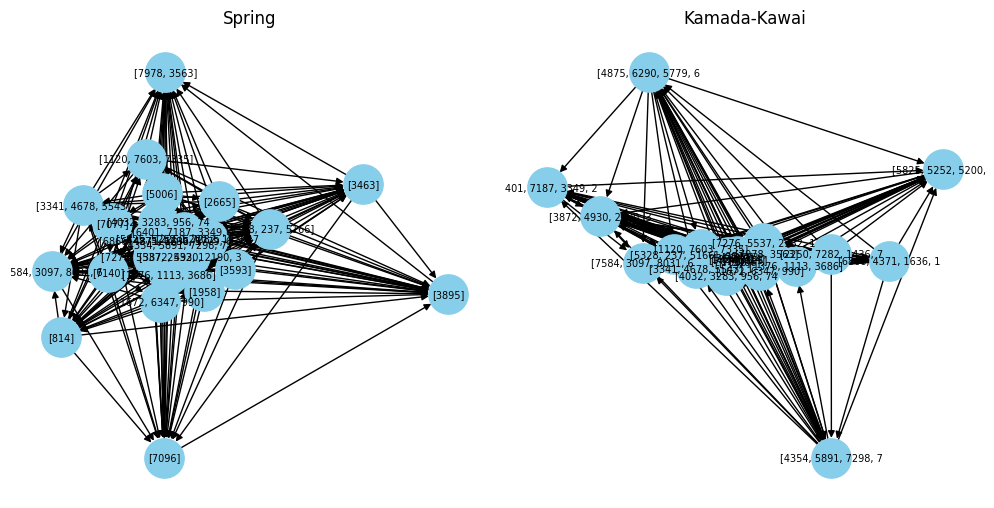

In [ ]:
layouts = {
     "Spring": nx.spring_layout(Q, seed=42, k=1.5),
    "Kamada-Kawai": nx.kamada_kawai_layout(Q),
    # "Circular": nx.circular_layout(Q),
    # "Shell": nx.shell_layout(Q),
    # "Spectral": nx.spectral_layout(Q)
}

plt.figure(figsize=(15,10))
for i, (name, pos) in enumerate(layouts.items(), 1):
    plt.subplot(2, 3, i)
    nx.draw(
        Q, pos, with_labels=True,
        labels={n: str(list(n))[:20] for n in Q.nodes},
        node_size=800, node_color="skyblue", font_size=7
    )
    plt.title(name)

plt.tight_layout()
plt.show()


In [ ]:
rows = [(mutation, comp_id)
        for comp_id, comp in enumerate(components)
        for mutation in comp]

clone_map = pd.DataFrame(rows, columns=["mutation_id", "clone"])

clone_map

,mutation_id,clone
0,7978,0
1,3563,0
2,3895,1
3,7096,2
4,7584,3
...,...,...
186,7276,24
187,5537,24
188,2532,24
189,1213,24


In [ ]:
clone_counts = clone_map.groupby("clone").size().reset_index(name="frequency")
clone_counts

,clone,frequency
0,0,2
1,1,1
2,2,1
3,3,4
4,4,1
5,5,3
6,6,3
7,7,1
8,8,3
9,9,3


In [ ]:
clone_map

,mutation_id,clone
0,7978,0
1,3563,0
2,3895,1
3,7096,2
4,7584,3
...,...,...
186,7276,24
187,5537,24
188,2532,24
189,1213,24


In [ ]:
clone_map_rho = pd.merge(clone_map, rho_clone, on="mutation_id", how="left")
clone_map_rho

,mutation_id,clone,mutation,A,B,copy_number_A
0,7978,0,9:89159199:T:C,1.0,0.142857,3.0
1,3563,0,20:47806414:C:T,1.0,0.133333,2.0
2,3895,1,2:128089725:C:G,1.0,0.181818,2.0
3,7096,2,7:97032987:G:C,1.0,0.222222,3.0
4,7584,3,8:79930870:A:G,1.0,0.250000,2.0
...,...,...,...,...,...,...
186,7276,24,8:137143880:T:C,0.0,0.666667,2.0
187,5537,24,4:73088743:A:T,0.0,0.666667,2.0
188,2532,24,18:60535416:T:C,0.0,0.666667,1.0
189,1213,24,12:98432927:G:A,0.0,0.666667,2.0


In [ ]:
clone_stats = (
    clone_map_rho.groupby("clone")
      .agg(mean_rho=("B", "mean"), n_mutations=("B", "size"), mean_rho_other=("A", "mean"), min_copy_other=("copy_number_A", "min"))
      .reset_index()
      .sort_values("mean_rho", ascending=False)
)

clone_stats

,clone,mean_rho,n_mutations,mean_rho_other,min_copy_other
14,14,0.952381,3,1.0,2.0
13,13,0.850919,44,1.0,1.0
25,25,0.818182,1,0.0,0.0
12,12,0.741435,18,1.0,1.0
24,24,0.666667,4,0.0,1.0
11,11,0.650635,22,1.0,1.0
23,23,0.600000,1,0.0,1.0
22,22,0.571429,1,0.0,2.0
10,10,0.554235,11,1.0,1.0
21,21,0.533333,1,0.0,2.0


In [ ]:
mutation_to_clone = dict(zip(clone_map["mutation_id"], clone_map["clone"]))
mapping = {node: mutation_to_clone[next(iter(node))] for node in Q.nodes()}
Q_relabelled = nx.relabel_nodes(Q, mapping)
Q_relabelled

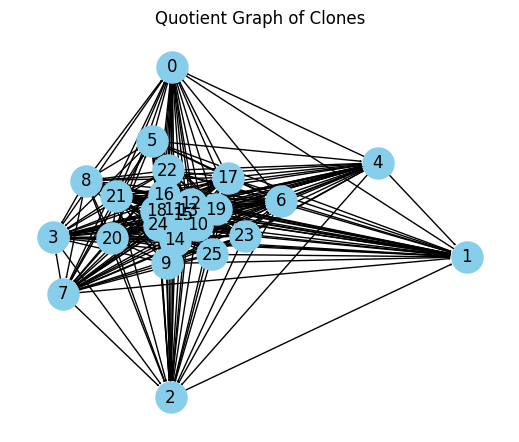

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Optionally, set a layout
pos = nx.spring_layout(Q_relabelled, seed=42, k=1.5)  # positions for all nodes

plt.figure(figsize=(5, 4))
nx.draw(
    Q_relabelled,
    pos,
    with_labels=True,      # show node labels (clone IDs)
    node_color='skyblue',  # node color
    node_size=500,        # size of nodes
    arrowsize=1,          # arrow size for directed edges
    font_size=12
)
plt.title("Quotient Graph of Clones")
plt.show()


In [ ]:
clone_ids = clone_stats["clone"].tolist()
mean_rho = np.array(clone_stats["mean_rho"].tolist())
mean_rho_other = np.array(clone_stats["mean_rho_other"].tolist())

print(clone_ids)
print(mean_rho)
print(mean_rho_other)

[14, 13, 25, 12, 24, 11, 23, 22, 10, 21, 20, 9, 8, 19, 7, 6, 18, 5, 4, 17, 16, 3, 2, 1, 0, 15]
[0.95238095 0.85091916 0.81818182 0.7414347  0.66666667 0.65063469
 0.6        0.57142857 0.55423545 0.53333333 0.5        0.5
 0.43386243 0.43175888 0.4        0.37121212 0.34165181 0.33333333
 0.28571429 0.28571429 0.25       0.25       0.22222222 0.18181818
 0.13809524 0.13001685]
[1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 0.]


In [ ]:
target = np.array(clone_stats.sort_values("clone", ascending=True)["mean_rho_other"])
target

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
import numpy as np
from collections import defaultdict
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

m = 1
n = len(clone_ids)
nodes = clone_ids    # 0..n-1
tol = 1e-9
epsilon = 0.01

O = np.eye(n)

params = {
    "WLSACCESSID": '85dfeec1-65a1-402f-9425-7465d0f3a229',
    "WLSSECRET": 'f755a3a4-dba0-444d-8bc8-d8e781d8a05c',
    "LICENSEID": 2687964,
}
env = gp.Env(params=params)

# Build ancestry arcs A
A = []
for j in range(n):
    for k in range(n):
        if j == k:
            continue

        if mean_rho_other[j] != mean_rho_other[k] and abs(mean_rho[j] - mean_rho[k]) < 0.01:
            if mean_rho_other[j] > mean_rho_other[k]:
                A.append((clone_ids[j], clone_ids[k]))

        else:
            if mean_rho[j] + tol >= mean_rho[k]:
                A.append((clone_ids[j], clone_ids[k]))


root = 'R'
A0 = list(A) + [(root, v) for v in nodes]

# bounds
f_tilde = mean_rho[np.argsort(clone_ids)].copy()
f_low = np.clip(f_tilde - epsilon, 0.0, 1.0)
f_high = np.clip(f_tilde + epsilon, 0.0, 1.0)

# --- Build MILP in gurobipy ---
mdl = Model("VAFFP_from_meanrho", env=env)

# Variables
x_vars = mdl.addVars(A0, vtype=GRB.BINARY, name="x")

f_vars = {
    (0, j): mdl.addVar(lb=float(f_low[int(j)]), ub=float(f_high[int(j)]), vtype=GRB.CONTINUOUS, name=f"f_0_{j}")
    for j in nodes
}

mutations_list = list(clone_ids)

B_vars = mdl.addVars([(c, m) for c in clone_ids for m in mutations_list], vtype=GRB.BINARY, name="B")

u_vars = {(0, j): mdl.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"u_0_{j}") for j in nodes}

mdl.update()

# Single root outgoing
mdl.addConstr(quicksum(x_vars[(root, v)] for v in nodes) == 1, "SingleRootOutgoing")

# adjacency maps
d_plus = defaultdict(list)
d_minus = defaultdict(list)
for (u, v) in A0:
    d_plus[u].append(v)
    d_minus[v].append(u)

# Parent incoming requirement
for (vk, vl) in A:
    mdl.addConstr(
        x_vars[(vk, vl)] <= quicksum(x_vars[(vj, vk)] for vj in d_minus[vk]),
        f"ParentIncoming_{vk}_{vl}"
    )

# At most one incoming
for vk in nodes:
    incs = [x_vars[(vj, vk)] for vj in d_minus[vk]]
    if incs:
        mdl.addConstr(quicksum(incs) <= 1, f"AtMostOneIncoming_{vk}")

# Sum condition
for j in nodes:
    children = d_plus[j]
    if children:
        mdl.addConstr(
            quicksum(f_vars[(0, k)] * x_vars[(j, k)] for k in children) <= f_vars[(0, j)],
            name=f"SumCondition_parent_{j}"
        )

# absolute deviation
for j in nodes:
    ft = float(f_tilde[int(j)])
    fvar = f_vars[(0, int(j))]
    uvar = u_vars[(0, int(j))]
    mdl.addConstr(uvar >= (ft - fvar), f"u_ge_posdiff_{j}")
    mdl.addConstr(uvar >= (fvar - ft), f"u_ge_negdiff_{j}")

## Calculating B
B_vars = mdl.addVars([(j, m) for j in nodes for m in mutations_list],
                     vtype=GRB.BINARY, name="B")

# 1. Fix observed mutations
for j in nodes:
    mdl.addConstr(B_vars[(j, j)] == 1, name=f"O_{j}_{m}")

# 2. Inheritance with indicator constraints
for (p, c) in A0:
    if p == root:
        continue
    for m in mutations_list:
        mdl.addGenConstrIndicator(
            x_vars[(p, c)], 1,
            B_vars[(c, m)] >= B_vars[(p, m)],
            name=f"inherit_{p}_{c}_{m}"
        )

# 3. (Optional) Consistency with observed O
for c in nodes:
    for m in mutations_list:
        if c == m:
            continue
        mdl.addConstr(
            B_vars[(c, m)] <= gp.quicksum(x_vars[(p, c)] * B_vars[(p, m)] for p in d_minus[c] if p != root),
            name=f"B_consistency_{c}_{m}"
        )


s = mdl.addVars(nodes, vtype=GRB.BINARY, name="s")
mdl.addConstr(sum(s[j] for j in nodes) == 1)  # select exactly one row

y = mdl.addVars(mutations_list, vtype=GRB.BINARY, name="y")

for m in mutations_list:
    mdl.addConstr(
        y[m] == gp.quicksum(B_vars[j, m] * s[j] for j in nodes)
    )

diff = mdl.addVars(mutations_list, vtype=GRB.BINARY, name="diff")

for m in mutations_list:
    if target[m] == 1:
        mdl.addConstr(diff[m] == 1 - y[m])
    else:
        mdl.addConstr(diff[m] == y[m])

alpha = 10000

mdl.setObjective(
    quicksum(x_vars[e] for e in x_vars)
    - (1.0 / (m * n)) * quicksum(u_vars[(0, j)] for j in nodes)
    - alpha * quicksum(diff[m] for m in mutations_list),  # penalize distance
    GRB.MAXIMIZE
)


# Solve
mdl.Params.TimeLimit = 60
mdl.optimize()

if mdl.status == GRB.OPTIMAL or mdl.status == GRB.TIME_LIMIT:
    selected = [(u, v) for (u, v) in A0 if x_vars[(u, v)].X > 0.5]
    print("Selected arcs:", selected)
    for (u, v) in selected:
        parent = 'R' if u == root else f"clone_{u}"
        child = f"clone_{v}"
        print(parent, "->", child)
else:
    print("No solution found. Status:", mdl.status)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2687964
Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd
Set parameter TimeLimit to value 60
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd
Optimize a model with 482 rows, 1833 columns and 3860 nonzeros
Model fingerprint: 0x025f9ea8
Model has 676 quadratic constraints
Model has 8450 simple general constraints
  8450 INDICATOR
Variable types: 52 continuous, 1781 integer (1781 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [3e-03, 1e+04]
  Bound

In [ ]:
n_nodes = len(nodes)
n_mutations = len(mutations_list)

X_matrix = np.zeros((n_nodes, n_mutations), dtype=int)

for j in nodes:
    for m in mutations_list:
        if (j, m) in x_vars:
            val = x_vars[(j, m)].X   # .X gives solution value
            X_matrix[j, m] = int(round(val))  # round to 0/1

print("X_matrix:")
print(X_matrix)

X_matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
n_nodes = len(nodes)
n_mutations = len(mutations_list)

B_matrix = np.zeros((n_nodes, n_mutations), dtype=int)

for j in nodes:
    for m in mutations_list:
        val = B_vars[(j, m)].X   # .X gives solution value
        B_matrix[j, m] = int(round(val))  # round to 0/1

print("B_matrix:")
print(B_matrix)

B_matrix:
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [ ]:
f_values = {j: f_vars[(0, j)].X for j in nodes}
clone_stats["f_current"] = clone_stats["clone"].map(f_values)

In [ ]:
f_values

{14: 0.9523809523809523,
 13: 0.8609191636302542,
 25: 0.8181818181818182,
 12: 0.7409023183416309,
 24: 0.6666666666666666,
 11: 0.650634694564181,
 23: 0.6,
 22: 0.5714285714285714,
 10: 0.5542354508861685,
 21: 0.5333333333333333,
 20: 0.5,
 9: 0.5,
 8: 0.4338624338624338,
 19: 0.43175888439046334,
 7: 0.4,
 6: 0.37121212121212127,
 18: 0.34165181224004754,
 5: 0.3333333333333333,
 4: 0.2857142857142857,
 17: 0.2857142857142857,
 16: 0.25,
 3: 0.25,
 2: 0.2222222222222222,
 1: 0.18181818181818182,
 0: 0.1380952380952381,
 15: 0.12001684528862332}

In [ ]:
clone_stats.sort_values(["mean_rho_other", "mean_rho"], ascending=False)

,clone,mean_rho,n_mutations,mean_rho_other,min_copy_other,f_current
14,14,0.952381,3,1.0,2.0,0.952381
13,13,0.850919,44,1.0,1.0,0.860919
12,12,0.741435,18,1.0,1.0,0.740902
11,11,0.650635,22,1.0,1.0,0.650635
10,10,0.554235,11,1.0,1.0,0.554235
9,9,0.500000,3,1.0,1.0,0.500000
8,8,0.433862,3,1.0,3.0,0.433862
7,7,0.400000,1,1.0,3.0,0.400000
6,6,0.371212,3,1.0,3.0,0.371212
5,5,0.333333,3,1.0,2.0,0.333333


In [ ]:
T = nx.DiGraph()
T.add_edges_from(selected)

In [ ]:
# !sudo apt-get install graphviz graphviz-dev
# !pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://a

/tmp/ipython-input-2253359526.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


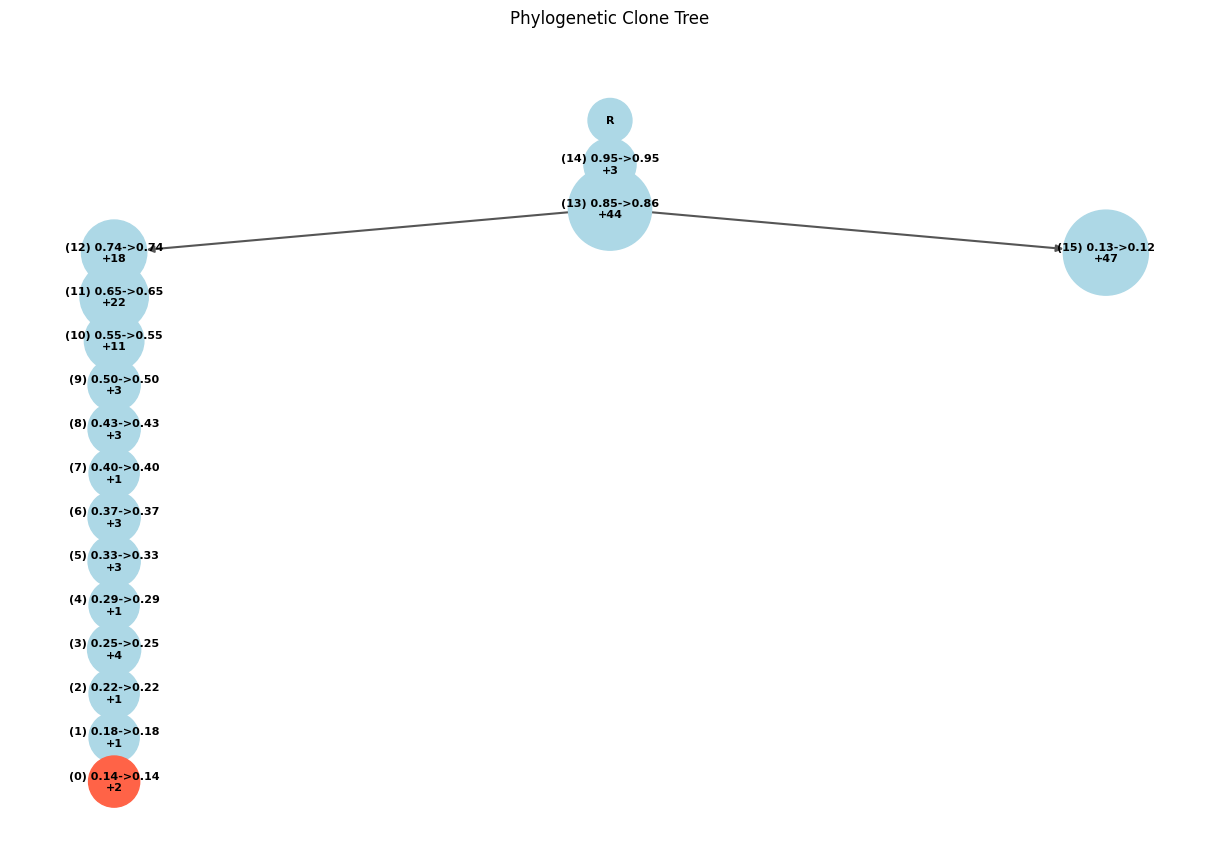

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming clone_stats is a DataFrame and T is a networkx DiGraph
# Example: info = clone_stats.set_index("clone").to_dict(orient="index")

def draw_clone_tree(T, clone_stats, s, output_file=None):
    # Extract node information
    info = clone_stats.set_index("clone").to_dict(orient="index")

    # Create labels with concise formatting
    labels = {}
    for node in T.nodes():
        if node in info:
            labels[node] = (
                f"({node}) {info[node]['mean_rho']:.2f}->{info[node]['f_current']:.2f}\n"
                f"+{info[node]['n_mutations']}"
            )
        else:
            labels[node] = str(node)

    # Node colors based on condition
    node_colors = ["#FF6347" if node in s and s[node].X > 0.5 else "#ADD8E6" for node in T.nodes()]

    # Node sizes based on mutation count (optional scaling)
    node_sizes = [2500 * (info[node]["n_mutations"] / max(info[n]["n_mutations"] for n in info) + 0.5)
                  if node in info else 1000 for node in T.nodes()]

    # Use graphviz 'dot' layout for hierarchical structure
    pos = nx.nx_agraph.graphviz_layout(T, prog="dot", args="-Gnodesep=.5 -Granksep=50")

    # Create figure with adjusted size
    plt.figure(figsize=(12, 8))

    # Draw the tree
    nx.draw(
        T,
        pos,
        labels=labels,
        node_size=node_sizes,
        node_color=node_colors,
        font_size=8,
        font_weight="bold",
        edge_color="#555555",
        width=1.5,
        arrows=True
    )

    # Add title and adjust layout
    plt.title("Phylogenetic Clone Tree", fontsize=12, pad=20)
    plt.tight_layout()

    # Save or display
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

# Example usage:
draw_clone_tree(T, clone_stats, s, output_file="clone_tree.png")

## Let's cluster the mutations

In [ ]:
filtered_rho

mutation,10:100129846:C:A,10:100185101:A:G,10:100209326:T:C,10:100283942:C:T,10:10086005:G:T,10:100873589:A:T,10:101108223:T:C,10:101427318:G:C,10:101884473:T:A,10:102329766:C:A,...,X:94344991:T:G,X:96387929:A:T,X:96987846:A:C,X:97291714:A:T,X:97396419:C:A,X:97564955:T:C,X:98452192:T:C,X:98700894:C:T,X:99136386:C:T,X:99571629:G:T
clone_id,,,,,,,,,,,,,,,,,,,,,
A,0.0,0.0,1.0,0.000000,0.833333,0.000000,0.000,0.000000,1.0,0.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000
B,0.0,0.0,1.0,0.000000,1.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000
C,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,1.000000,0.0,0.000000
D,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,1.000000,0.0,0.000000
E,1.0,1.0,1.0,0.784314,0.000000,1.000000,0.625,0.606061,1.0,1.0,...,1.0,0.0,0.933333,0.0,0.769231,0.095238,0.0,0.952381,1.0,0.000000
F,1.0,1.0,1.0,1.000000,0.000000,0.190476,1.000,0.000000,1.0,1.0,...,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,1.0,0.000000
G,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,1.0,0.000000,1.0,0.000000,1.000000,0.0,1.000000,0.0,0.909091
H,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,1.0,0.000000,1.0,0.000000,1.000000,0.0,1.000000,0.0,1.000000
I,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000,0.000000,1.0,0.0,...,1.0,1.0,0.000000,1.0,0.000000,1.000000,0.0,1.000000,0.0,1.000000


In [ ]:
clone_ids = ["A", "B", "C"]

In [ ]:
rho_clone = (
    filtered_rho.loc[clone_ids]
    .T
    .reset_index().reset_index()
    .rename(columns={"index": "mutation_id"})
    .set_index(["mutation_id"])
)
rho_clone

clone_id,mutation,A,B,C
mutation_id,,,,
0,10:100129846:C:A,0.000000,0.0,0.0
1,10:100185101:A:G,0.000000,0.0,0.0
2,10:100209326:T:C,1.000000,1.0,1.0
3,10:100283942:C:T,0.000000,0.0,0.0
4,10:10086005:G:T,0.833333,1.0,0.0
...,...,...,...,...
8318,X:97564955:T:C,0.000000,0.0,0.0
8319,X:98452192:T:C,0.000000,0.0,1.0
8320,X:98700894:C:T,1.000000,1.0,1.0


### Let's first build a graph for each clone

In [ ]:
threshold = 0.025

In [ ]:
def get_clone_fractional(rho_clone, clone_id):
    rho_clone_filt = rho_clone[clone_id]
    rho_clone_filt = rho_clone_filt[(rho_clone_filt > 0) & (rho_clone_filt < 1)]
    return rho_clone_filt

In [ ]:
import networkx as nx


def build_graph_for_clone(clone_ccf, threshold=0.025):

    G = nx.DiGraph()
    mutations = clone_ccf.index.tolist()

    G.add_nodes_from(mutations)

    for i in mutations:
        for j in mutations:
            if i <= j:
                continue

            rho_i = clone_ccf.loc[i]
            rho_j = clone_ccf.loc[j]
            diff = rho_i - rho_j

            if abs(diff) < threshold:
                # bidirectional
                G.add_edge(i, j)
                G.add_edge(j, i)
            elif diff > 0:
                # Fi > Fj -> i -> j
                G.add_edge(i, j)
            else:
                # Fj > Fi -> j -> i
                G.add_edge(j, i)

    return G

In [ ]:
rho_A = get_clone_fractional(rho_clone, "A")
rho_B = get_clone_fractional(rho_clone, "B")
rho_C = get_clone_fractional(rho_clone, "C")

In [ ]:
GA = build_graph_for_clone(rho_A, threshold=0.02)
GB = build_graph_for_clone(rho_B)
GC = build_graph_for_clone(rho_C)

In [ ]:
def form_mutation_groups_for_cluster(current_clone_id, GA, rho_A):

    components = list(nx.strongly_connected_components(GA))

    mean_fs = []

    for component in components:
        mutations_in_component = list(component)
        filt = rho_A[mutations_in_component]

        mean_fs.append(np.mean(filt))

    sorted_index = np.argsort(mean_fs)

    mutation_groups = {}
    for j in sorted_index:
        component = components[j]
        mutations_in_component = list(component)
        for i in range(len(mutations_in_component)):
            mutation_i = mutations_in_component[i]

            other_clone_str = f"{current_clone_id}_{j:02}_"
            for clone_id in clone_ids:
                if clone_id != current_clone_id:
                    rho = rho_clone.loc[mutation_i, clone_id]
                    if rho > 0.5: other_clone_str += "1"
                    else: other_clone_str += "0"

            if other_clone_str not in mutation_groups:
                mutation_groups[other_clone_str] = []

            mutation_groups[other_clone_str].append(mutation_i)

    mutation_groups_list = list(mutation_groups.keys())

    G = nx.DiGraph()
    G.add_nodes_from(mutation_groups_list)

    for i in range(len(mutation_groups_list)):
        for j in range(i + 1, len(mutation_groups_list)):
            group_name_i = mutation_groups_list[i]
            group_name_j = mutation_groups_list[j]

            if group_name_i[:4] == group_name_j[:4]:
                G.add_edge(group_name_i, group_name_j)
                G.add_edge(group_name_j, group_name_i)
            elif group_name_i[:4] > group_name_j[:4]:
                G.add_edge(group_name_i, group_name_j)
            else:
                G.add_edge(group_name_j, group_name_i)
    return G, mutation_groups

In [ ]:
G_A, mut_grp_A = form_mutation_groups_for_cluster("A", GA, rho_A)
G_B, mut_grp_B = form_mutation_groups_for_cluster("B", GB, rho_B)
G_C, mut_grp_C = form_mutation_groups_for_cluster("C", GC, rho_C)

In [ ]:
G_A.number_of_nodes(), G_B.number_of_nodes(), G_C.number_of_nodes()

(29, 30, 23)

In [ ]:
all_known_ids = set(rho_A.index) | set(rho_B.index) | set(rho_C.index)

rho_clone_filtered = rho_clone[~rho_clone.index.isin(all_known_ids)]
rho_clone_filtered = rho_clone_filtered.loc[~(rho_clone_filtered[clone_ids] == 0).all(axis=1)]
rho_clone_filtered

clone_id,mutation,A,B,C
mutation_id,,,,
2,10:100209326:T:C,1.0,1.0,1.0
8,10:101884473:T:A,1.0,1.0,1.0
20,10:10576117:A:T,1.0,1.0,1.0
34,10:107190989:T:C,1.0,1.0,0.0
54,10:109948428:G:C,1.0,1.0,1.0
...,...,...,...,...
8301,X:9024460:G:A,1.0,1.0,1.0
8312,X:93975389:T:A,1.0,1.0,1.0
8313,X:94344991:T:G,1.0,1.0,1.0


In [ ]:
mutations_in_pool = list(rho_clone_filtered.index)

mutation_groups = {}

for i in range(len(mutations_in_pool)):
    mutation_i = mutations_in_pool[i]

    other_clone_str = f"P_"
    for clone_id in clone_ids:
        rho = rho_clone.loc[mutation_i, clone_id]
        if rho > 0.5: other_clone_str += "1"
        else: other_clone_str += "0"

    if other_clone_str not in mutation_groups:
        mutation_groups[other_clone_str] = []

    mutation_groups[other_clone_str].append(mutation_i)

for k, v in mutation_groups.items():
    print(k, len(v))

P_111 447
P_110 89
P_001 133
P_100 48
P_011 19
P_101 27
P_010 10


In [ ]:
pool_mutations = list(mutation_groups.keys())
pool_mutations

['P_111', 'P_110', 'P_001', 'P_100', 'P_011', 'P_101', 'P_010']

In [ ]:
cluster_order = ["C", "B", "A"]

In [ ]:
# Build ancestry arcs A
A = []

Gs = [G_A, G_B, G_C]
mut_grps = [mut_grp_A, mut_grp_B, mut_grp_C]

cluster_entries = [f"E_{clone_id}" for clone_id in clone_ids]

root = "R"

## Root to cluster entries
A = [(root, cluster_entry) for cluster_entry in cluster_entries]

## Cluster entry to respective pool mutation
t = []
for clone_id, cluster_entry in zip(clone_ids, cluster_entries):
    for pool_mutation in pool_mutations:
        t.append((cluster_entry, f"{clone_id}_{pool_mutation}"))
A.extend(t)

## Respective pool with each other
t = []
for clone_id in clone_ids:
    for pool_mutation_1 in pool_mutations:
        for pool_mutation_2 in pool_mutations:
            if pool_mutation_1 == pool_mutation_2: continue
            t.append((f"{clone_id}_{pool_mutation_1}", f"{clone_id}_{pool_mutation_2}"))
A.extend(t)

## One pool to another pool
t = []
for i in range(len(cluster_order) - 1):
    j = i + 1
    cluster_i = cluster_order[i]
    cluster_j = cluster_order[j]
    for pool_mutation in pool_mutations:
        t.append((f"{cluster_i}_{pool_mutation}", f"E_{cluster_j}"))
A.extend(t)

## Pool to cluster root
cluster_roots = [f"R_{clone_id}" for clone_id in clone_ids]
t = []
for clone_id, cluster_root in zip(clone_ids, cluster_roots):
    for pool_mutation in pool_mutations:
        t.append((f"{clone_id}_{pool_mutation}", cluster_root))
A.extend(t)

## Entry to cluster root
t = []
for cluster_entry, cluster_root in zip(cluster_entries, cluster_roots):
    t.append((cluster_entry, cluster_root))
A.extend(t)

## Cluster roots to all cluster nodes
for G, cluster_root in zip(Gs, cluster_roots):
    for node in G.nodes():
        A.append((cluster_root, node))

## All from Gs
for G in Gs:
    for edge in G.edges():
        A.append(edge)

## All nodes of G to entry
t = []
order_indices = np.argsort(cluster_order)
for l in range(len(order_indices) - 1):
    i = order_indices[l]
    j = order_indices[l + 1]
    Gi = Gs[i]
    cluster_entry_j = cluster_entries[j]
    for node in Gi.nodes():
        t.append((node, cluster_entry_j))
print(t)
A.extend(t)

print(A)
print(G_A.number_of_nodes() + G_B.number_of_nodes() + G_C.number_of_nodes())
print(len(A))

[('C_00_00', 'E_B'), ('C_00_11', 'E_B'), ('C_00_01', 'E_B'), ('C_01_11', 'E_B'), ('C_01_00', 'E_B'), ('C_02_11', 'E_B'), ('C_03_00', 'E_B'), ('C_04_11', 'E_B'), ('C_04_00', 'E_B'), ('C_05_11', 'E_B'), ('C_05_00', 'E_B'), ('C_05_01', 'E_B'), ('C_06_11', 'E_B'), ('C_06_00', 'E_B'), ('C_07_00', 'E_B'), ('C_07_11', 'E_B'), ('C_08_00', 'E_B'), ('C_08_11', 'E_B'), ('C_09_11', 'E_B'), ('C_10_00', 'E_B'), ('C_10_11', 'E_B'), ('C_10_10', 'E_B'), ('C_10_01', 'E_B'), ('B_00_00', 'E_A'), ('B_00_01', 'E_A'), ('B_00_10', 'E_A'), ('B_01_00', 'E_A'), ('B_01_10', 'E_A'), ('B_01_01', 'E_A'), ('B_02_00', 'E_A'), ('B_02_10', 'E_A'), ('B_03_10', 'E_A'), ('B_03_01', 'E_A'), ('B_03_00', 'E_A'), ('B_04_10', 'E_A'), ('B_04_01', 'E_A'), ('B_04_11', 'E_A'), ('B_05_10', 'E_A'), ('B_05_01', 'E_A'), ('B_06_10', 'E_A'), ('B_06_00', 'E_A'), ('B_06_01', 'E_A'), ('B_06_11', 'E_A'), ('B_07_10', 'E_A'), ('B_07_00', 'E_A'), ('B_07_11', 'E_A'), ('B_07_01', 'E_A'), ('B_08_10', 'E_A'), ('B_08_11', 'E_A'), ('B_09_10', 'E_A'),

In [ ]:
mutations = []
for G in Gs:
    mutations.extend(list(G.nodes()))
for clone_id in clone_ids:
    mutations.extend([f"{clone_id}_{mutation}" for mutation in pool_mutations])
mutations

['A_00_00',
 'A_00_01',
 'A_00_11',
 'A_01_00',
 'A_02_00',
 'A_02_01',
 'A_03_00',
 'A_03_01',
 'A_04_00',
 'A_05_00',
 'A_06_00',
 'A_06_11',
 'A_07_00',
 'A_07_10',
 'A_07_11',
 'A_08_11',
 'A_08_10',
 'A_08_00',
 'A_08_01',
 'A_09_00',
 'A_09_10',
 'A_09_11',
 'A_10_00',
 'A_10_10',
 'A_10_11',
 'A_11_10',
 'A_11_11',
 'A_11_00',
 'A_11_01',
 'B_00_00',
 'B_00_01',
 'B_00_10',
 'B_01_00',
 'B_01_10',
 'B_01_01',
 'B_02_00',
 'B_02_10',
 'B_03_10',
 'B_03_01',
 'B_03_00',
 'B_04_10',
 'B_04_01',
 'B_04_11',
 'B_05_10',
 'B_05_01',
 'B_06_10',
 'B_06_00',
 'B_06_01',
 'B_06_11',
 'B_07_10',
 'B_07_00',
 'B_07_11',
 'B_07_01',
 'B_08_10',
 'B_08_11',
 'B_09_10',
 'B_09_11',
 'B_09_00',
 'B_10_11',
 'C_00_00',
 'C_00_11',
 'C_00_01',
 'C_01_11',
 'C_01_00',
 'C_02_11',
 'C_03_00',
 'C_04_11',
 'C_04_00',
 'C_05_11',
 'C_05_00',
 'C_05_01',
 'C_06_11',
 'C_06_00',
 'C_07_00',
 'C_07_11',
 'C_08_00',
 'C_08_11',
 'C_09_11',
 'C_10_00',
 'C_10_11',
 'C_10_10',
 'C_10_01',
 'A_P_111',
 'A_

In [ ]:
targets = {}

target = {}
for mutation in mutations:
    if mutation[2] == "P":
        if mutation[4] == "1": target[mutation] = 1
        else: target[mutation] = 0
    elif mutation.startswith("A_"):
        target[mutation] = 0
    else:
        if mutation[5] == "1": target[mutation] = 1
        else: target[mutation] = 0

targets["A"] = target

target = {}
for mutation in mutations:
    if mutation[2] == "P":
        if mutation[5] == "1": target[mutation] = 1
        else: target[mutation] = 0
    elif mutation.startswith("B_"):
        target[mutation] = 0
    elif mutation.startswith("A_"):
        if mutation[5] == "1": target[mutation] = 1
        else: target[mutation] = 0
    elif mutation.startswith("C_"):
        if mutation[6] == "1": target[mutation] = 1
        else: target[mutation] = 0
targets["B"] = target

target = {}
for mutation in mutations:
    if mutation[2] == "P":
        if mutation[6] == "1": target[mutation] = 1
        else: target[mutation] = 0
    elif mutation.startswith("C_"):
        target[mutation] = 0
    elif mutation.startswith("A_") or mutation.startswith("B_"):
        if mutation[6] == "1": target[mutation] = 1
        else: target[mutation] = 0
targets["C"] = target
targets

{'A': {'A_00_00': 0,
  'A_00_01': 0,
  'A_00_11': 0,
  'A_01_00': 0,
  'A_02_00': 0,
  'A_02_01': 0,
  'A_03_00': 0,
  'A_03_01': 0,
  'A_04_00': 0,
  'A_05_00': 0,
  'A_06_00': 0,
  'A_06_11': 0,
  'A_07_00': 0,
  'A_07_10': 0,
  'A_07_11': 0,
  'A_08_11': 0,
  'A_08_10': 0,
  'A_08_00': 0,
  'A_08_01': 0,
  'A_09_00': 0,
  'A_09_10': 0,
  'A_09_11': 0,
  'A_10_00': 0,
  'A_10_10': 0,
  'A_10_11': 0,
  'A_11_10': 0,
  'A_11_11': 0,
  'A_11_00': 0,
  'A_11_01': 0,
  'B_00_00': 0,
  'B_00_01': 0,
  'B_00_10': 1,
  'B_01_00': 0,
  'B_01_10': 1,
  'B_01_01': 0,
  'B_02_00': 0,
  'B_02_10': 1,
  'B_03_10': 1,
  'B_03_01': 0,
  'B_03_00': 0,
  'B_04_10': 1,
  'B_04_01': 0,
  'B_04_11': 1,
  'B_05_10': 1,
  'B_05_01': 0,
  'B_06_10': 1,
  'B_06_00': 0,
  'B_06_01': 0,
  'B_06_11': 1,
  'B_07_10': 1,
  'B_07_00': 0,
  'B_07_11': 1,
  'B_07_01': 0,
  'B_08_10': 1,
  'B_08_11': 1,
  'B_09_10': 1,
  'B_09_11': 1,
  'B_09_00': 0,
  'B_10_11': 1,
  'C_00_00': 0,
  'C_00_11': 1,
  'C_00_01': 0,
  '

In [ ]:
import numpy as np
from collections import defaultdict
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

In [ ]:
params = {
    "WLSACCESSID": '85dfeec1-65a1-402f-9425-7465d0f3a229',
    "WLSSECRET": 'f755a3a4-dba0-444d-8bc8-d8e781d8a05c',
    "LICENSEID": 2687964,
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2687964
Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd


In [ ]:
# --- Build MILP in gurobipy ---
mdl = Model("VAFFP_from_meanrho", env=env)

# Variables
x_vars = mdl.addVars(A, vtype=GRB.BINARY, name="x")
for v in x_vars.values():
    v.Start = 0

In [ ]:
# bounds
import numpy as np

epsilon = 0.3


f_tilde = {}
f_low = {}
f_high = {}

for clone_id, mut_grp in zip(clone_ids, mut_grps):
    for k, v in mut_grp.items():
        rho = np.mean(rho_clone.loc[v, clone_id])
        f_tilde[k] = rho
        f_low[k] = np.clip(rho - epsilon, 0.0, 1.0)
        f_high[k] = np.clip(rho + epsilon, 0.0, 1.0)

print(f_tilde)
print(f_low)
print(f_high)

{'A_00_00': np.float64(0.08676216752085097), 'A_00_01': np.float64(0.09548229548229548), 'A_00_11': np.float64(0.08), 'A_01_00': np.float64(0.2), 'A_02_00': np.float64(0.2222222222222222), 'A_02_01': np.float64(0.2222222222222222), 'A_03_00': np.float64(0.25), 'A_03_01': np.float64(0.25), 'A_04_00': np.float64(0.2792207792207792), 'A_05_00': np.float64(0.3125), 'A_06_00': np.float64(0.3333333333333333), 'A_06_11': np.float64(0.3333333333333333), 'A_07_00': np.float64(0.43948397433158376), 'A_07_10': np.float64(0.442937062937063), 'A_07_11': np.float64(0.4380952380952381), 'A_08_11': np.float64(0.5587901645836798), 'A_08_10': np.float64(0.5666798284681227), 'A_08_00': np.float64(0.5657285488112556), 'A_08_01': np.float64(0.5), 'A_09_00': np.float64(0.6605222734254993), 'A_09_10': np.float64(0.6636668225027272), 'A_09_11': np.float64(0.6666666666666666), 'A_10_00': np.float64(0.6896551724137931), 'A_10_10': np.float64(0.6896551724137931), 'A_10_11': np.float64(0.6896551724137931), 'A_11_

In [ ]:
mutations_in_clones = list(f_tilde.keys())

In [ ]:
f_vars = {
    j: mdl.addVar(lb=float(f_low[j]), ub=float(f_high[j]), vtype=GRB.CONTINUOUS, name=f"f_{j}")
    for j in mutations_in_clones
}

In [ ]:
# Single root outgoing
mdl.addConstr(quicksum(x_vars[(root, v)] for v in cluster_entries) == 1, "SingleMainRootOutgoing")
for cluster_root, G in zip(cluster_roots, Gs):
    mdl.addConstr(quicksum(x_vars[(cluster_root, v)] for v in G.nodes()) == 1, f"SingleRootOutgoing_{cluster_root}")
for cluster_entry in cluster_entries:
    cluster_entry_list = []
    for (u, v) in A:
        if u == cluster_entry:
            cluster_entry_list.append((u, v))
    mdl.addConstr(quicksum(x_vars[p] for p in cluster_entry_list) == 1, f"SingleEntryOutgoing_{cluster_entry}")

In [ ]:
# adjacency maps
d_plus = defaultdict(list)
d_minus = defaultdict(list)
for (u, v) in A:
    d_plus[u].append(v)
    d_minus[v].append(u)

In [ ]:
for (vk, vl) in A:
    if vk == root:
        continue
    mdl.addConstr(
        x_vars[(vk, vl)] <= quicksum(x_vars[(vj, vk)] for vj in d_minus[vk]),
        f"ParentIncoming_{vk}_{vl}"
    )

In [ ]:
all_nodes_in_A = []
for (vk, vl) in A:
    all_nodes_in_A.append(vk)
    all_nodes_in_A.append(vl)
all_nodes_in_A = list(set(all_nodes_in_A))
len(all_nodes_in_A)

110

In [ ]:
# At most one incoming
for vk in all_nodes_in_A:
    incs = [x_vars[(vj, vk)] for vj in d_minus[vk]]
    if incs:
        mdl.addConstr(quicksum(incs) <= 1, f"AtMostOneIncoming_{vk}")

In [ ]:
# Sum condition
for G in Gs:
    nodes = list(G.nodes())
    for j in nodes:
        children_in_cluster = [d for d in d_plus[j] if d in f_vars]
        if children_in_cluster:
            mdl.addConstr(
                quicksum(f_vars[k] * x_vars[(j, k)] for k in children_in_cluster) <= f_vars[j],
                name=f"SumCondition_parent_{j}"
            )

In [ ]:
u_vars = {}
for G in Gs:
    nodes = list(G.nodes())
    for j in nodes:
        u_vars = u_vars | {j: mdl.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"u_0_{j}") for j in nodes}

In [ ]:
# absolute deviation
for G in Gs:
    nodes = list(G.nodes())
    for j in nodes:
        ft = float(f_tilde[j])
        fvar = f_vars[j]
        uvar = u_vars[j]
        mdl.addConstr(uvar >= (ft - fvar), f"u_ge_posdiff_{j}")
        mdl.addConstr(uvar >= (fvar - ft), f"u_ge_negdiff_{j}")

In [ ]:
## Tree inside grouped clone mutations using depth variables

mutation_group_clusters = defaultdict(list)
for mutation in mutations_in_clones:
    mutation_group_clusters[mutation[:4]].append(mutation)

d_vars = {v: mdl.addVar(vtype=GRB.INTEGER, lb=0, name=f"d_{v}") for v in mutations_in_clones}
for mutation_group_name, mutation_group_members in mutation_group_clusters.items():
    for (u,v) in A:
        if u in mutation_group_members and v in mutation_group_members:
            mdl.addGenConstrIndicator(x_vars[(u,v)], 1, d_vars[v] >= d_vars[u] + 1, name=f"depth_{u}_{v}")

In [ ]:
## Tree inside pooled mutations

pooled_mutations_cluster = [f"{clone_id}_{pool_mutation}" for clone_id in clone_ids for pool_mutation in pool_mutations]

d_pooled_vars = {v: mdl.addVar(vtype=GRB.INTEGER, lb=0, name=f"d_pooled_{v}") for v in pooled_mutations_cluster}

for (u, v) in A:
    if u in pooled_mutations_cluster and v in pooled_mutations_cluster and u[0] == v[0]:
        mdl.addGenConstrIndicator(x_vars[(u, v)], 1, d_pooled_vars[v] >= d_pooled_vars[u] + 1, name=f"depth_pooled_{u}_{v}")

In [ ]:
## Only one among pool mutations
## ?
# for pool_mutation in pool_mutations:
#     incs = []
#     for clone_id in clone_ids:
#         v = f"{clone_id}_{pool_mutation}"
#         incs.extend([x_vars[vj, v] for vj in d_minus[v]])
#     if incs:
#         mdl.addConstr(quicksum(incs) <= 1, f"AtMostOneIncomingForPool_{clone_id}")

In [ ]:
## There must for entry into cluster
# ## ?
# for cluster_entry in cluster_entries:
#     v = cluster_entry
#     incs = [x_vars[vj, v] for vj in d_minus[v]]
#     if incs:
#         mdl.addConstr(quicksum(incs) == 1, f"OneIncomingForEntry_{cluster_entry}")

In [ ]:
## Calculating B
all_nodes_in_A_except_root = [node for node in all_nodes_in_A if node != root]
B_vars = mdl.addVars([(j, m) for j in all_nodes_in_A_except_root for m in all_nodes_in_A_except_root],
                     vtype=GRB.BINARY, name="B")

In [ ]:
# 1. Fix observed mutations
for j in nodes:
    mdl.addConstr(B_vars[(j, j)] == 1, name=f"O_{j}_{j}")

In [ ]:
# 2. Inheritance with indicator constraints
for (p, c) in A:
    if p == root:
        continue
    for m in all_nodes_in_A_except_root:
        mdl.addGenConstrIndicator(
            x_vars[(p, c)], 1,
            B_vars[(c, m)] >= B_vars[(p, m)],
            name=f"inherit_{p}_{c}_{m}"
        )

In [ ]:
# 3. Consistency with observed O
for c in all_nodes_in_A_except_root:
    for m in all_nodes_in_A_except_root:
        if c == m:
            continue
        mdl.addConstr(
            B_vars[(c, m)] <= gp.quicksum(x_vars[(p, c)] * B_vars[(p, m)] for p in d_minus[c] if p != root),
            name=f"B_consistency_{c}_{m}"
        )

In [ ]:
diff = {}

# for clone_id in clone_ids:
#     for mutation in mutations:
#         if targets[clone_id][mutation] == 1:
#             diff[(clone_id, mutation)] = mdl.addVar(vtype=GRB.BINARY, name=f"diff_{clone_id}_{mutation}")

for clone_id in clone_ids:
    cluster_root = f"R_{clone_id}"
    for mutation in mutations:
        if targets[clone_id][mutation] == 1:
            diff[(clone_id, mutation)] = 1 - B_vars[(cluster_root, mutation)]

In [ ]:
mdl.update()

In [ ]:
num_mutations = 0

for G in Gs:
    num_mutations += len(G.nodes())

for k, v in mutation_groups.items():
    num_mutations += 1

m = n = num_mutations

In [ ]:
alpha = 100

mdl.setObjective(
    quicksum(x_vars[e] for e in x_vars)
    - (1.0 / (m * n)) * quicksum(u_vars[j] for j in u_vars)
    - alpha * quicksum(diff[p] for p in diff)
    ,  # penalize distance
    GRB.MAXIMIZE
)

In [ ]:
# Solve
mdl.Params.TimeLimit = 18000
mdl.optimize()

Set parameter TimeLimit to value 18000
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  18000

Academic license 2687964 - for non-commercial use only - registered to sa___@iict.buet.ac.bd
Optimize a model with 1899 rows, 15827 columns and 19467 nonzeros
Model fingerprint: 0x1c0b7297
Model has 11746 quadratic constraints
Model has 162466 simple general constraints
  162466 INDICATOR
Variable types: 2352 continuous, 13475 integer (13372 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-04, 1e+02]
  Bounds range     [1e-02, 1e+00]
  RHS range        [8e-02, 1e+00]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]

User MIP start did not produce a ne

In [ ]:
if mdl.status == GRB.OPTIMAL or mdl.status == GRB.TIME_LIMIT:
    selected = [(u, v) for (u, v) in A if x_vars[(u, v)].X > 0.5]
    print("Selected arcs:", selected)
    for (u, v) in selected:
        print(u, "->", v)
else:
    print("No solution found. Status:", mdl.status)

Selected arcs: [('R', 'E_C'), ('E_A', 'A_P_110'), ('E_B', 'B_P_010'), ('E_C', 'C_P_010'), ('A_P_111', 'A_P_011'), ('A_P_111', 'A_P_010'), ('A_P_110', 'A_P_001'), ('A_P_001', 'A_P_101'), ('A_P_100', 'A_P_111'), ('A_P_101', 'A_P_100'), ('B_P_111', 'B_P_100'), ('B_P_110', 'B_P_011'), ('B_P_001', 'B_P_101'), ('B_P_101', 'B_P_110'), ('B_P_010', 'B_P_111'), ('B_P_010', 'B_P_001'), ('C_P_111', 'C_P_001'), ('C_P_001', 'C_P_011'), ('C_P_100', 'C_P_111'), ('C_P_100', 'C_P_110'), ('C_P_011', 'C_P_101'), ('C_P_010', 'C_P_100'), ('C_P_110', 'E_B'), ('A_P_011', 'R_A'), ('B_P_100', 'R_B'), ('C_P_101', 'R_C'), ('R_A', 'A_11_11'), ('R_B', 'B_10_11'), ('R_C', 'C_10_10'), ('A_00_01', 'A_00_11'), ('A_02_00', 'A_00_00'), ('A_03_00', 'A_03_01'), ('A_03_01', 'A_02_01'), ('A_04_00', 'A_00_01'), ('A_04_00', 'A_02_00'), ('A_05_00', 'A_03_00'), ('A_06_00', 'A_04_00'), ('A_06_11', 'A_06_00'), ('A_07_00', 'A_01_00'), ('A_07_00', 'A_05_00'), ('A_07_10', 'A_07_11'), ('A_07_11', 'A_07_00'), ('A_08_11', 'A_08_01'), ('

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_clone_tree(T):

    # Create labels with concise formatting
    labels = {node: str(node) for node in T.nodes()}

    # Use graphviz 'dot' layout for hierarchical structure
    pos = nx.nx_agraph.graphviz_layout(T, prog="dot", args="-Gnodesep=.5 -Granksep=50")

    # Define a color map by first letter
    color_map = {
        'A': 'red',
        'B': 'blue',
        'C': 'green',
        'D': 'orange',
        'E': 'purple',
    }

    # Assign colors to nodes based on first letter (default: gray if unknown)
    node_colors = [
        color_map.get(str(node)[0], "gray") for node in T.nodes()
    ]

    # Create figure with adjusted size
    plt.figure(figsize=(12, 8))

    # Draw the tree with node colors
    nx.draw(
        T,
        pos,
        labels=labels,
        font_size=7,
        font_weight="bold",
        node_size=1000,
        edge_color="#555555",
        width=1.5,
        arrows=True,
        node_color=node_colors
    )

    # Add title and adjust layout
    plt.title("Phylogenetic Clone Tree", fontsize=12, pad=0)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-2778450075.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


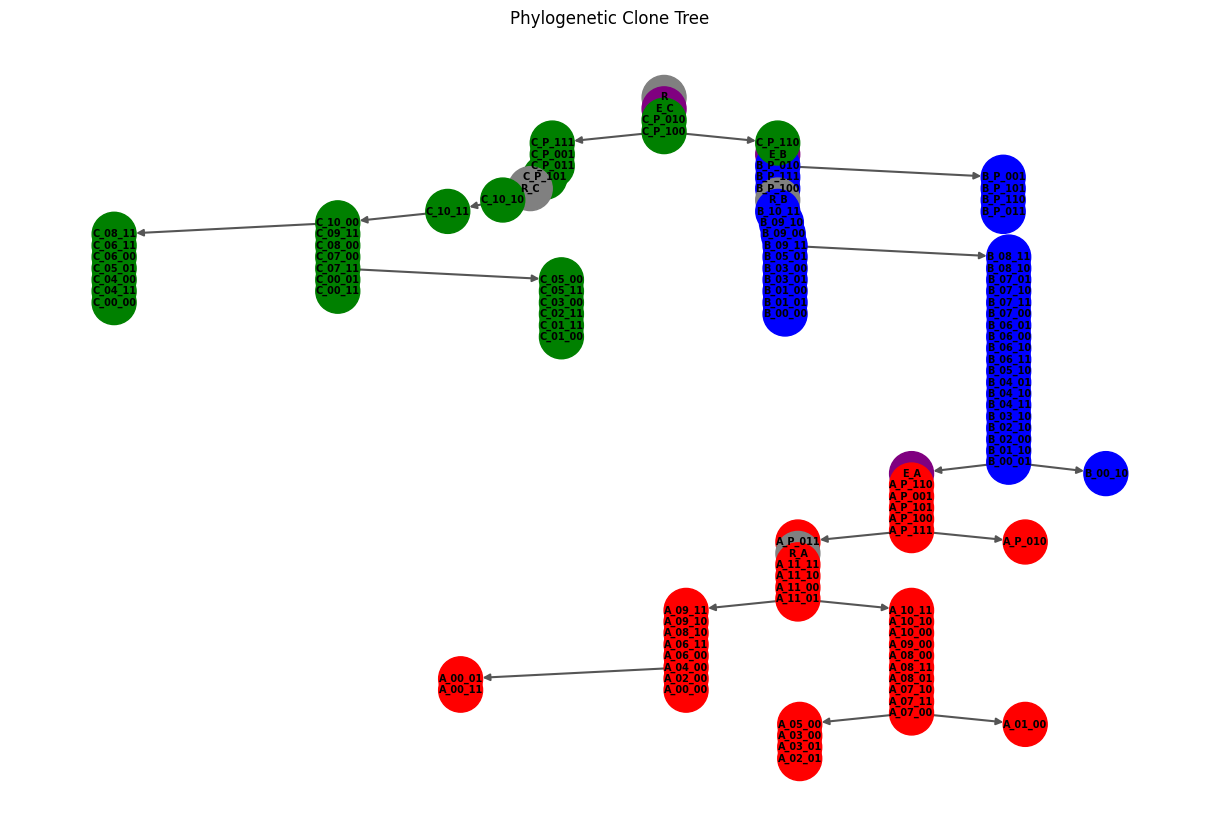

In [ ]:
T = nx.DiGraph()
T.add_edges_from(selected)
draw_clone_tree(T)

In [ ]:
for (u, v) in A:
    if (u == 'A_P_110' or v == 'A_P_110') and x_vars[(u, v)].X > 0.5:
        print(u, v, x_vars[(u, v)].X)


In [ ]:
for mutation1 in all_nodes_in_A_except_root:
    for mutation2 in all_nodes_in_A_except_root:
        print(int(B_vars[(mutation1, mutation2)].X > 0), end="")
    print()

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
0000000000